<a href="https://colab.research.google.com/github/SarkarPriyanshu/Machine-Learning-Models/blob/main/Health_Insurance_Cross_Sell_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install feature-engine -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 KB 12.3 MB/s eta 0:00:00


In [3]:
!pip install keras-tuner --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 7.6 MB/s eta 0:00:00


## Libraries

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.pipeline import Pipeline
from feature_engine.encoding import OneHotEncoder
from sklearn.model_selection import train_test_split
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Dropout,BatchNormalization

import keras_tuner as kt

import warnings
warnings.filterwarnings('ignore')


## Data Gathering

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d anmolkumar/health-insurance-cross-sell-prediction

 77% 5.00M/6.47M [00:00<00:00, 40.0MB/s]
100% 6.47M/6.47M [00:00<00:00, 48.6MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/health-insurance-cross-sell-prediction.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
df =  pd.read_csv('/content/train.csv')

## Data Assesment

- `id`	Unique ID for the customer (Remove this columns)
- `Gender`	Gender of the customer (Categorical)
- `Age`	Age of the customer (Numeric)
- `Driving_License`	0 : Customer does not have DL, 1 : Customer already has DL (Categorical)
- `Region_Code`	Unique code for the region of the customer (Numeric)
- `Previously_Insured`	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance (Categorical)
-`Vehicle_Age`	Age of the Vehicle (Numeric)
-`Vehicle_Damage`	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past. (Categorical)
-`Annual_Premium`	The amount customer needs to pay as premium in the year (Numeric)
-`Policy_Sales_Channel`	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
-`Vintage`	Number of Days, Customer has been associated with the company (Numeric)
-`Response`	1 : Customer is interested, 0 : Customer is not *interested* (Target)

#### Observation of Assesment
  - Imbalance dataset in terms of target feature, policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company `87.74%` response is `No` where only `12.25%` response is `Yes`.
  - No Null values to handle
  - Need to Drop Id feature from dataset
  - `Vehicle_Age` is a categorical feature that need to be preprocessed 


## Basic Analysis

In [9]:
df.shape

(381109, 12)

In [10]:
df.sample(25)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
38397,38398,Female,55,1,28.0,1,1-2 Year,No,2630.0,26.0,21,0
352468,352469,Female,29,1,35.0,1,< 1 Year,No,41404.0,152.0,212,0
269676,269677,Male,54,1,8.0,0,1-2 Year,Yes,44691.0,7.0,13,1
347329,347330,Female,22,1,8.0,0,< 1 Year,No,31916.0,160.0,98,0
214840,214841,Female,40,1,28.0,1,1-2 Year,No,38702.0,124.0,132,0
247936,247937,Male,53,1,28.0,0,1-2 Year,Yes,36625.0,26.0,85,0
59609,59610,Male,20,1,13.0,0,< 1 Year,Yes,17895.0,160.0,36,0
355562,355563,Female,26,1,46.0,1,< 1 Year,No,21486.0,152.0,118,0
314700,314701,Male,52,1,28.0,0,1-2 Year,Yes,42017.0,26.0,229,0
42107,42108,Female,23,1,6.0,1,< 1 Year,No,28762.0,152.0,180,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [12]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [13]:
df.corr()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,1.000000,0.001561,-0.000564,-0.000572,0.002457,0.003027,-0.002837,-0.000630,-0.001368
Age,0.001561,1.000000,-0.079782,0.042574,-0.254682,0.067507,-0.577826,-0.001264,0.111147
Driving_License,-0.000564,-0.079782,1.000000,-0.001081,0.014969,-0.011906,0.043731,-0.000848,0.010155
Region_Code,-0.000572,0.042574,-0.001081,1.000000,-0.024659,-0.010588,-0.042420,-0.002750,0.010570
Previously_Insured,0.002457,-0.254682,0.014969,-0.024659,1.000000,0.004269,0.219381,0.002537,-0.341170
Annual_Premium,0.003027,0.067507,-0.011906,-0.010588,0.004269,1.000000,-0.113247,-0.000608,0.022575
Policy_Sales_Channel,-0.002837,-0.577826,0.043731,-0.042420,0.219381,-0.113247,1.000000,0.000002,-0.139042
Vintage,-0.000630,-0.001264,-0.000848,-0.002750,0.002537,-0.000608,0.000002,1.000000,-0.001050
Response,-0.001368,0.111147,0.010155,0.010570,-0.341170,0.022575,-0.139042,-0.001050,1.000000


In [14]:
df.duplicated().sum()

0

In [15]:
df.skew()

id                      9.443274e-16
Age                     6.725390e-01
Driving_License        -2.159518e+01
Region_Code            -1.152664e-01
Previously_Insured      1.677471e-01
Annual_Premium          1.766087e+00
Policy_Sales_Channel   -9.000081e-01
Vintage                 3.029517e-03
Response                2.301906e+00
dtype: float64

#### Observation of Basic Analysis
  - `0 Null values` to handle
  - `Annual_Premium` having outliers
  - One hot encoding required in `Vehicle_Age`,`Gender` &	`Vehicle_Damage`.
  - `0 Duplicated rows` 
  - Skewed features need for `transformations` 	

## EDA

### Uni-variant Analysis

In [16]:
df.drop('id',axis=1,inplace=True)

In [17]:
target = 'Response'
numeric_features =  [feature for feature in df.columns if feature != target and (df[feature].dtype == 'int' or df[feature].dtype == 'float')]
categorical_features =  [feature for feature in df.columns  if feature != target and (df[feature].dtype != 'int' and df[feature].dtype != 'float')]

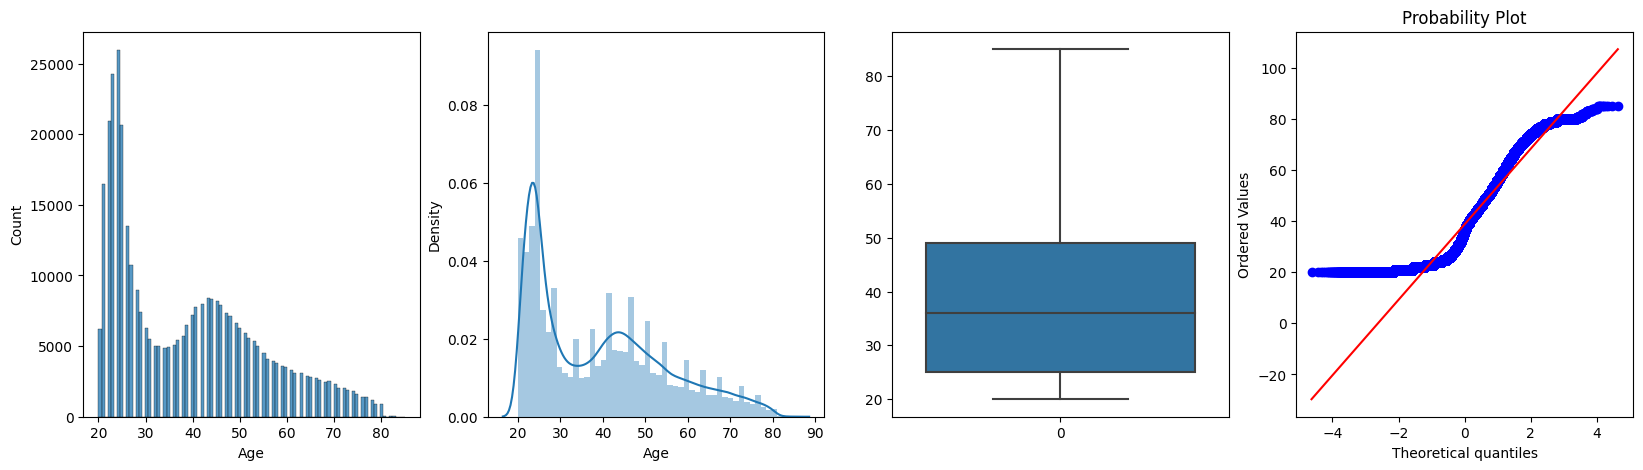

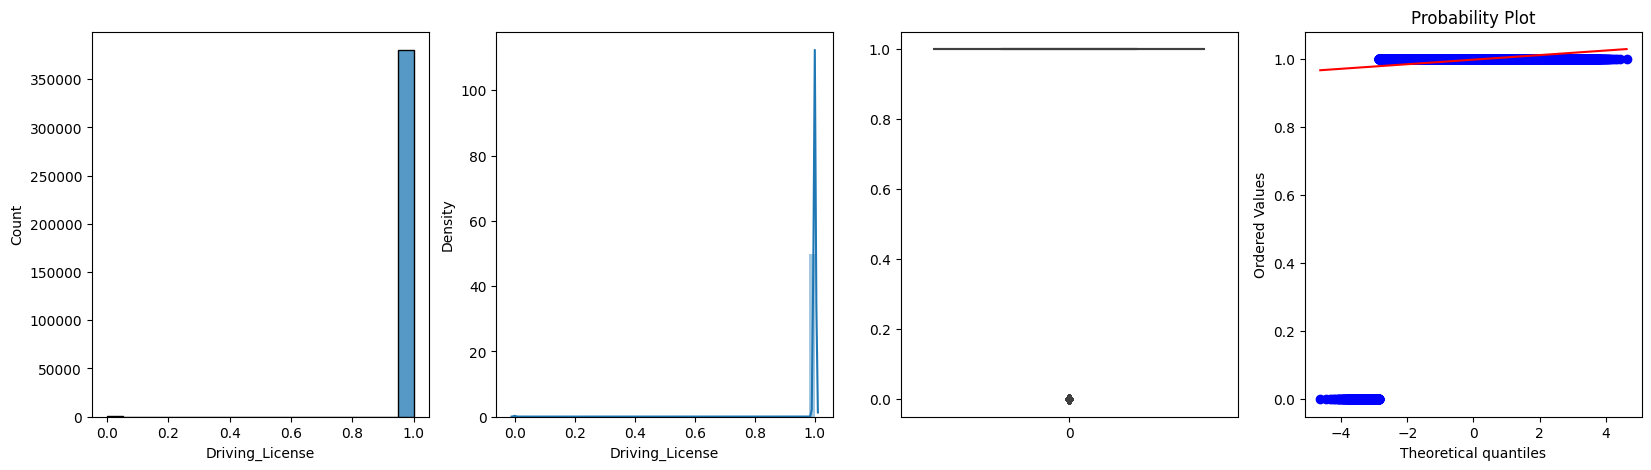

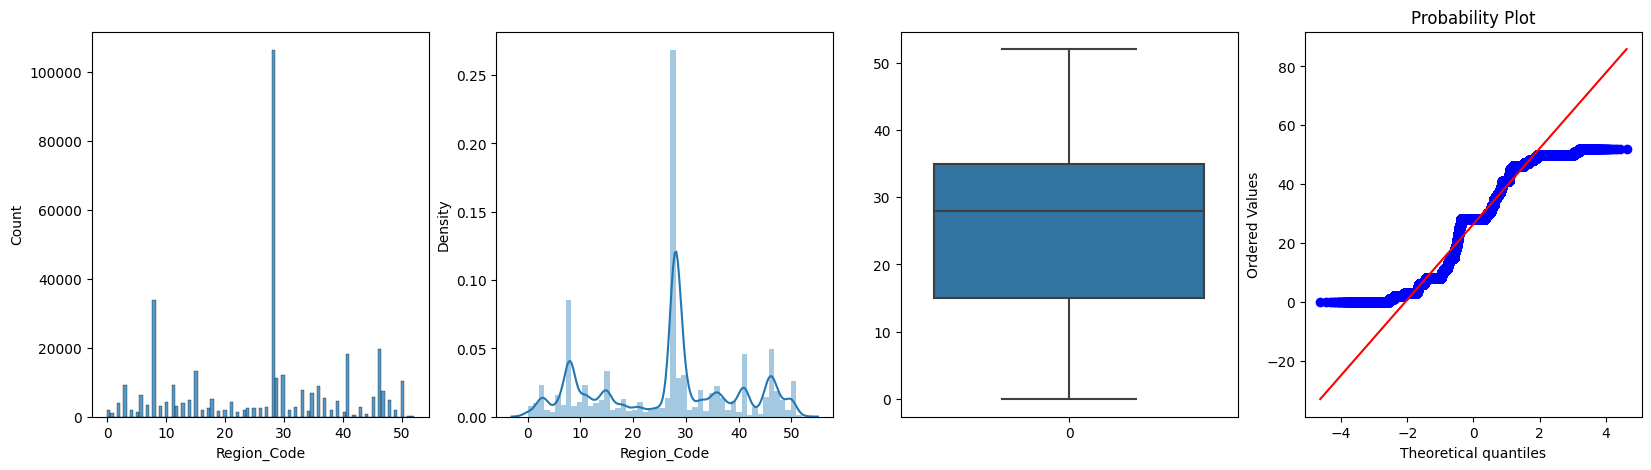

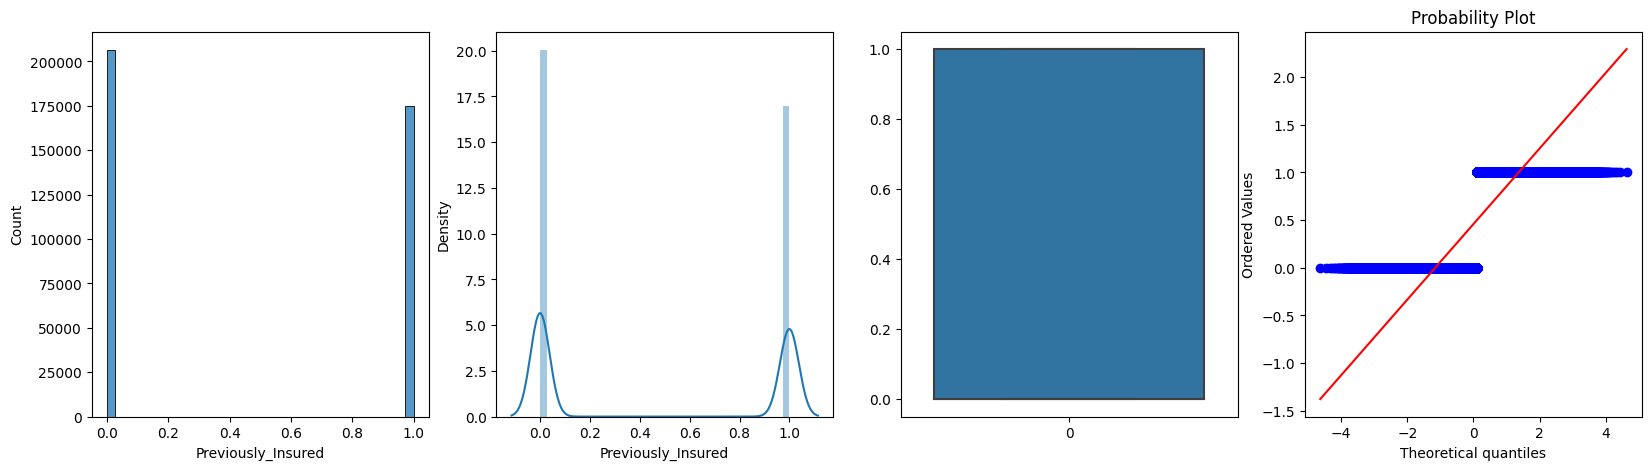

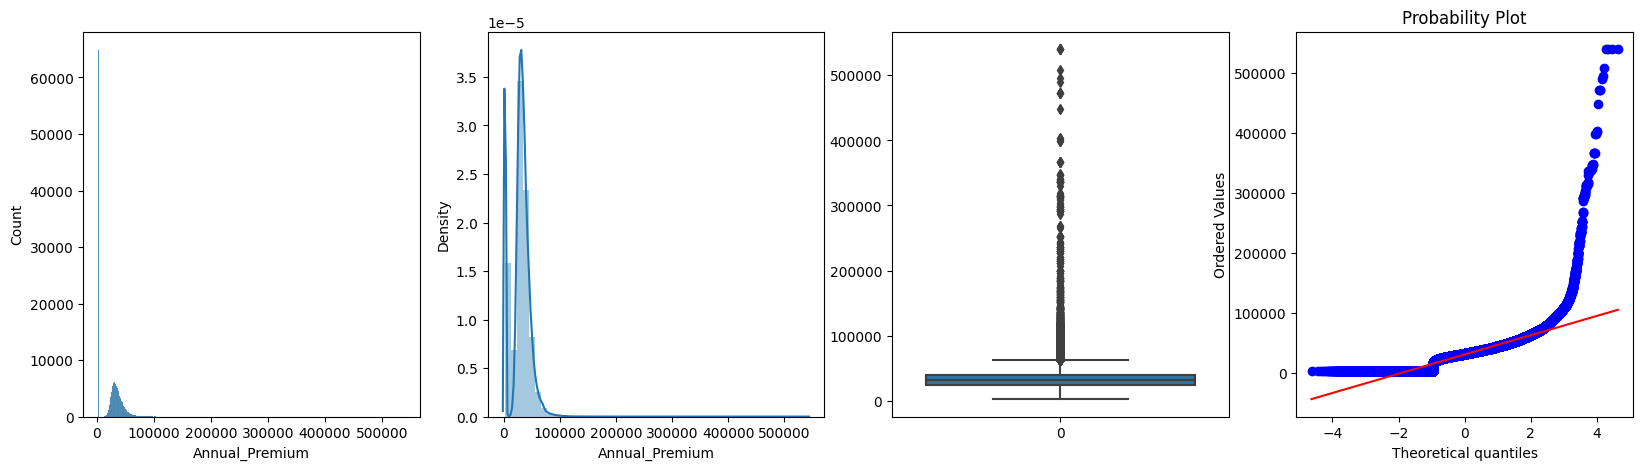

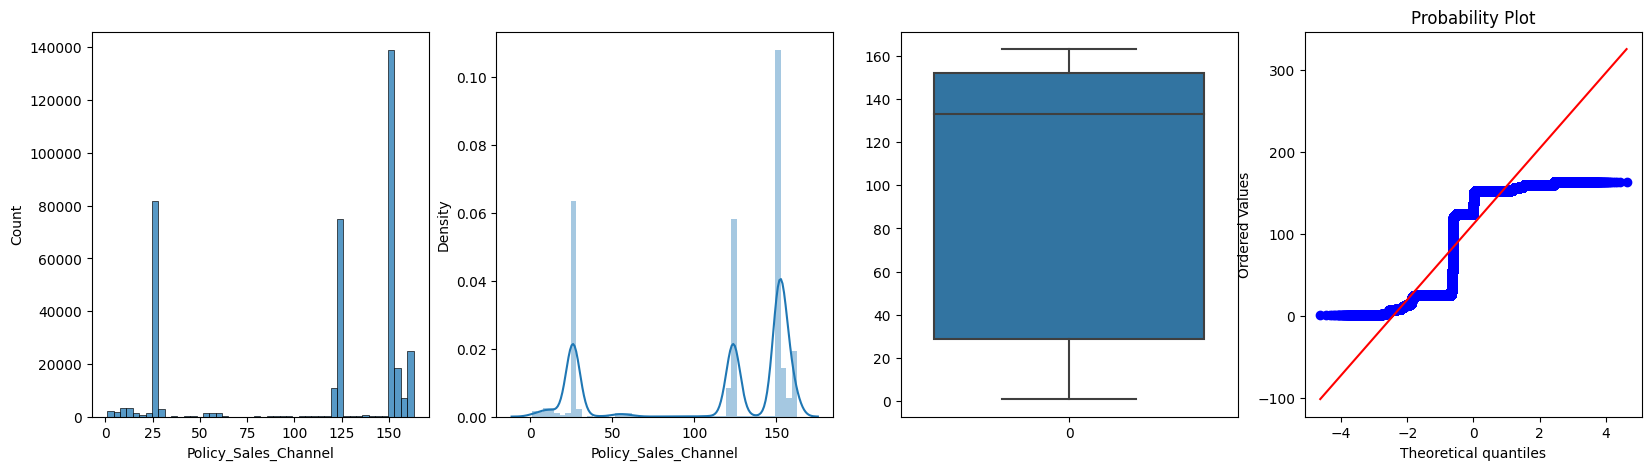

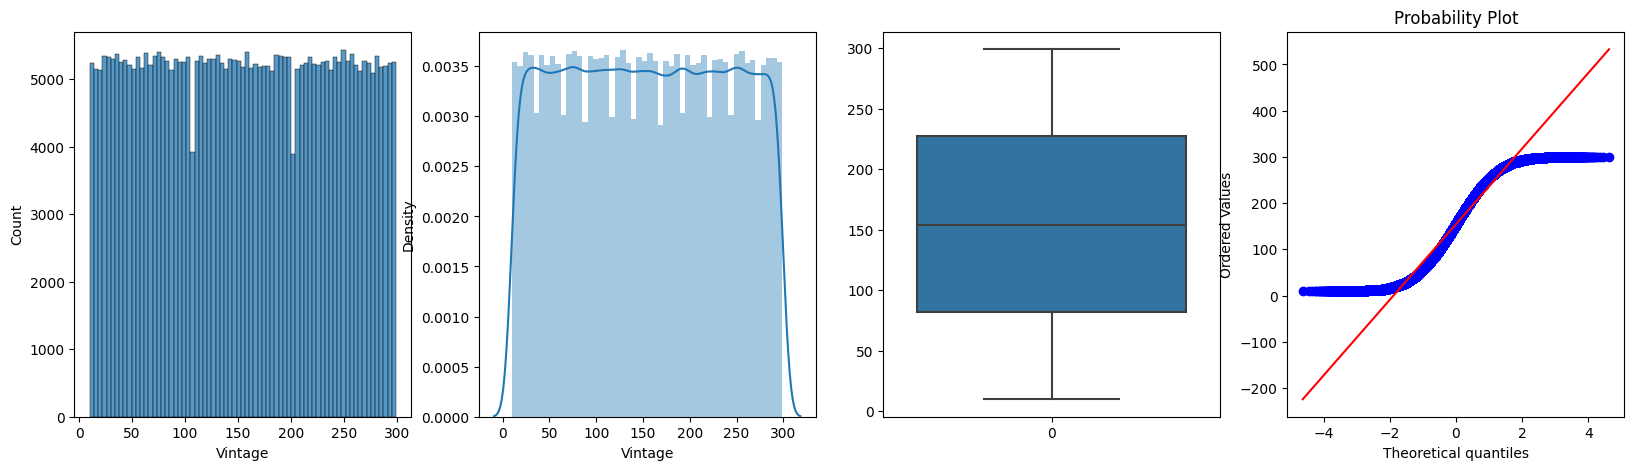

In [18]:
for feature in numeric_features:
  fig, ax = plt.subplots(1,4,figsize=(20, 5))
  sns.histplot(df[feature], ax=ax[0])
  sns.distplot(df[feature], ax=ax[1])
  sns.boxplot(df[feature],ax=ax[2])
  stats.probplot(df[feature], plot=ax[3], fit=True)
  fig.show()

#### Observation of univarient analysis for numeric features
  - `Outliers` in `Annual_Premium` feature
  - `Skewed` distribution of features

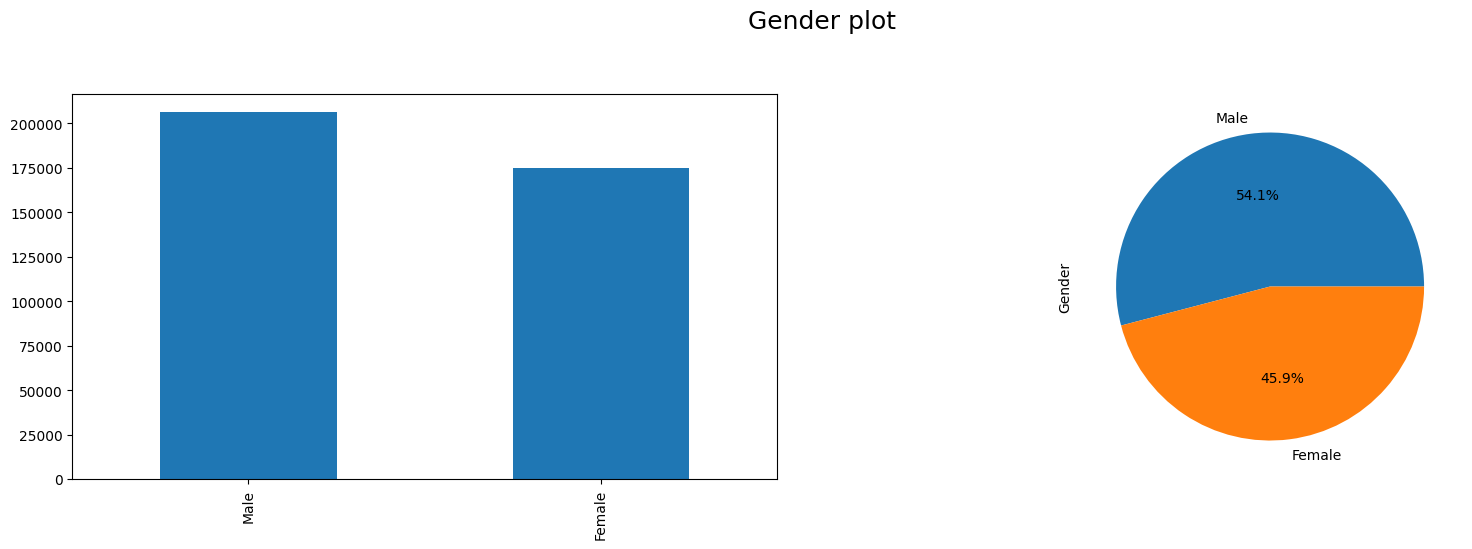

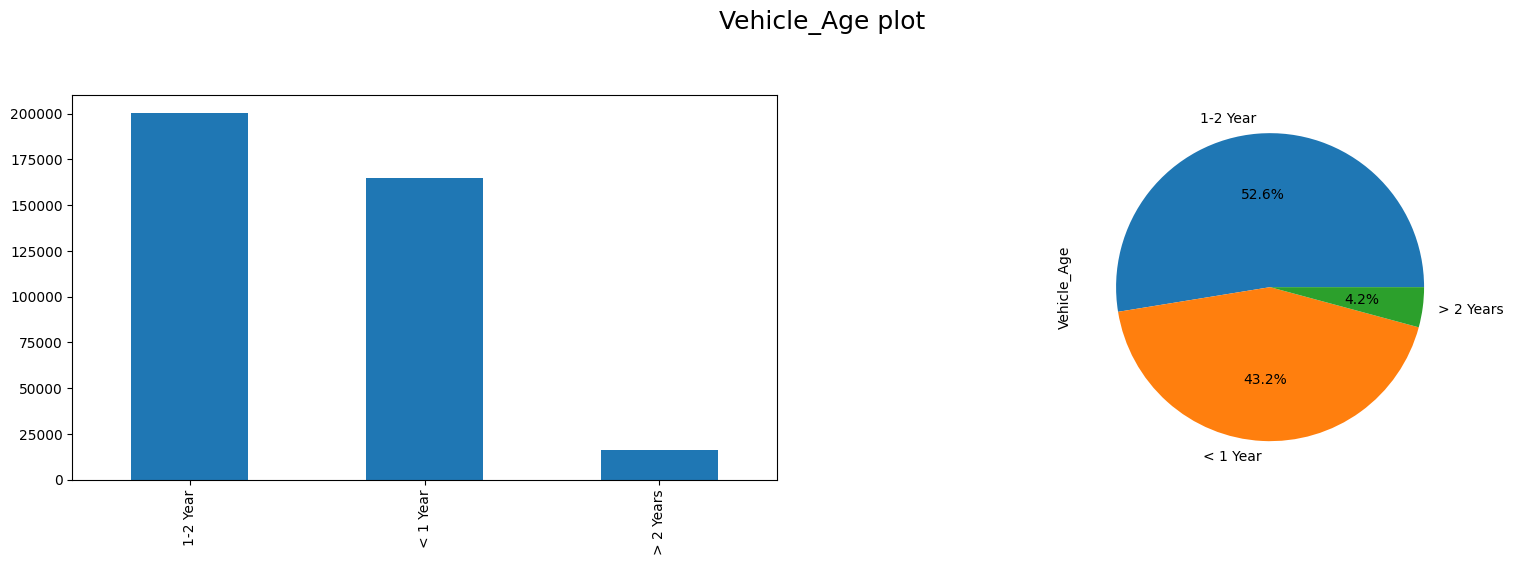

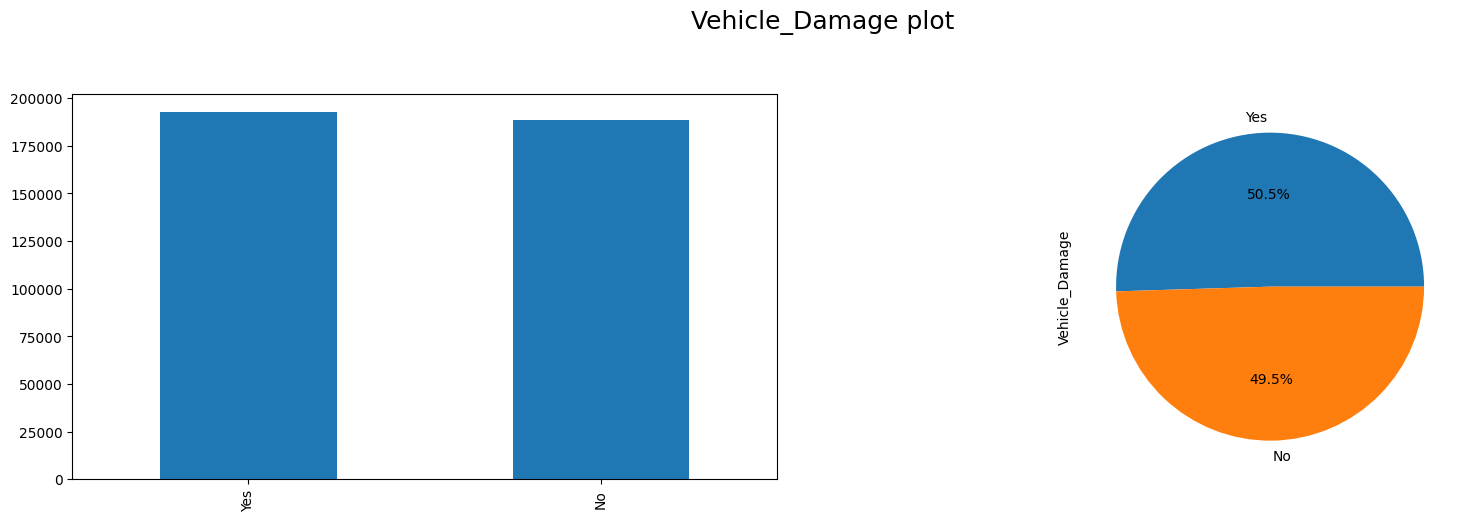

In [19]:
for feature in categorical_features:
  fig, ax = plt.subplots(1,2,figsize=(20, 5))
  df[feature].value_counts().plot(kind='bar',ax=ax[0])
  df[feature].value_counts().plot(kind='pie', autopct='%1.1f%%',ax=ax[1])
  plt.suptitle(f'{feature} plot', y=1.05, fontsize=18)
  fig.show()

#### Observation in categorical features
  - Vehical age had an uneven distribution of classes 

In [20]:
for category in df['Vehicle_Age'].unique():
  print(f'Mean of {category} for Annual_Premium', df[(df['Vehicle_Age'] == category) & (df['Response'] == 1)]['Annual_Premium'].mean(),'for response 1',df[(df['Vehicle_Age'] == category) & (df['Response'] == 0)]['Annual_Premium'].mean(),'for response 0')
  print(f'Standard deviation of {category} for Annual_Premium', df[(df['Vehicle_Age'] == category) & (df['Response'] == 1)]['Annual_Premium'].std(),'for response 1',df[(df['Vehicle_Age'] == category) & (df['Response'] == 0)]['Annual_Premium'].std(),'for response 0')
  print(f'Variance of {category} for Annual_Premium', df[(df['Vehicle_Age'] == category) & (df['Response'] == 1)]['Annual_Premium'].var(),'for response 1',df[(df['Vehicle_Age'] == category) & (df['Response'] == 0)]['Annual_Premium'].mean(),'for response 0')
  print()

Mean of > 2 Years for Annual_Premium 38236.02084219481 for response 1 34580.787527642635 for response 0
Standard deviation of > 2 Years for Annual_Premium 19440.3047463162 for response 1 20292.447672575145 for response 0
Variance of > 2 Years for Annual_Premium 377925448.6296442 for response 1 34580.787527642635 for response 0

Mean of 1-2 Year for Annual_Premium 31075.800264322243 for response 1 30407.45315690895 for response 0
Standard deviation of 1-2 Year for Annual_Premium 18684.152068684114 for response 1 18540.349365452777 for response 0
Variance of 1-2 Year for Annual_Premium 349097538.5257129 for response 1 30407.45315690895 for response 0

Mean of < 1 Year for Annual_Premium 29827.422660372118 for response 1 30132.903099299423 for response 0
Standard deviation of < 1 Year for Annual_Premium 16971.5827349102 for response 1 14874.481767498606 for response 0
Variance of < 1 Year for Annual_Premium 288034620.52790195 for response 1 30132.903099299423 for response 0



#### Observation 
  - We had comparied `vehicle age`, `Annual Premium` mean, std and var in terms of `Response` 
  - There not much of a difference in there `mean`, `std` and `variance`.
  - so we can say that the age of vehicle for both `response 1` and `response 0` is unbiased
  - we can conclude that even though the distribution of vehicle age category is imbalance but the relation with target column i.e `response` is balanced

### Bivarient Analysis
  - We are going to investigate about outlier and will they play any importance in our prediction or we can remove them completely.

In [21]:
# Annual Premium 5 number summary
def getsummary(feature):
  Q3 = np.percentile(df[feature], 75, axis=0)
  Q1 = np.percentile(df[feature], 25, axis=0)
  IQR = Q3-Q1
  upper_bound = Q3 + 1.5 * IQR
  lower_bound = Q1 - 1.5 * IQR
  return (Q1,Q3,IQR,upper_bound,lower_bound)

Age Age
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.0


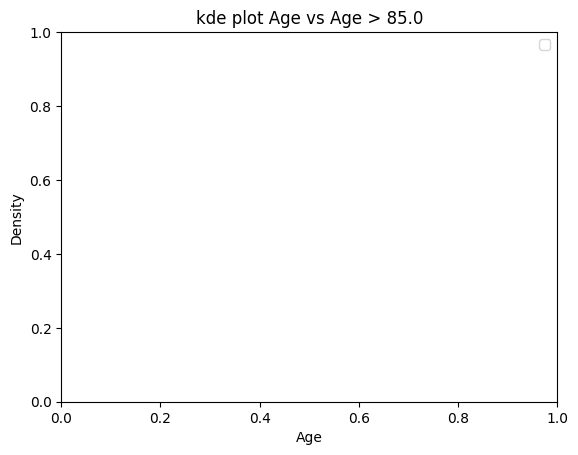

Age Driving_License
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.1


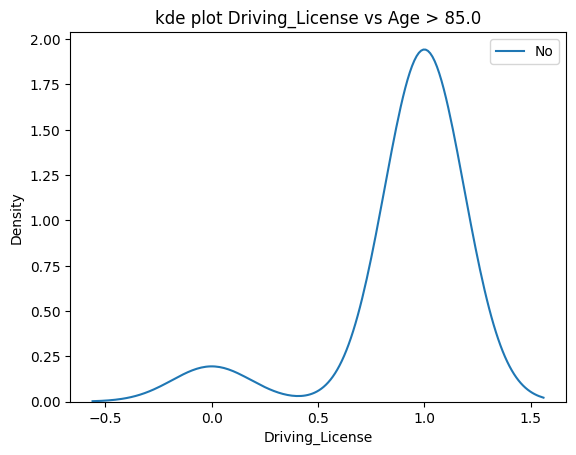

Age Region_Code
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.2


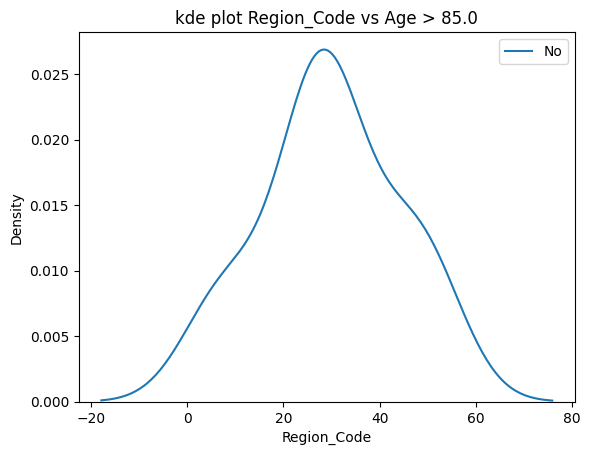

Age Previously_Insured
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.3


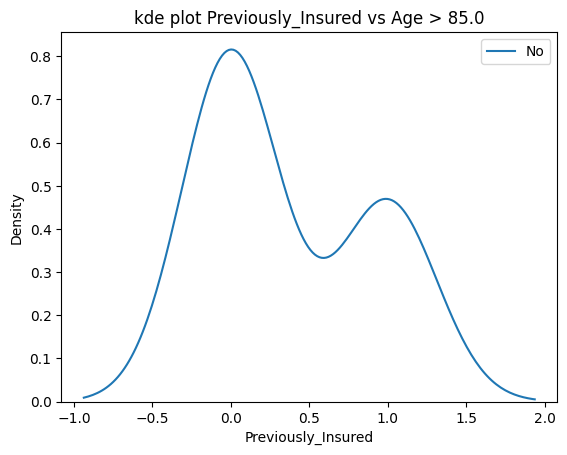

Age Annual_Premium
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.4


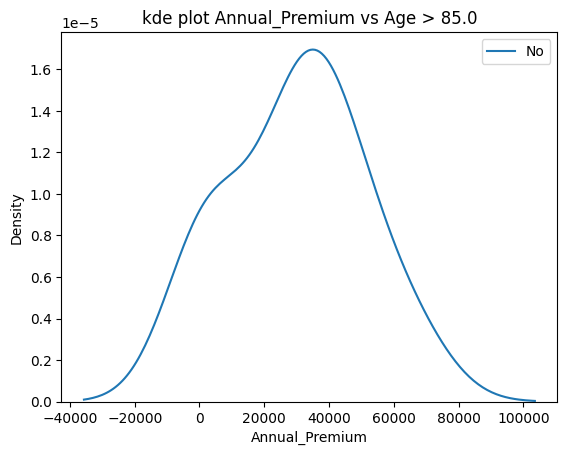

Age Policy_Sales_Channel
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.5


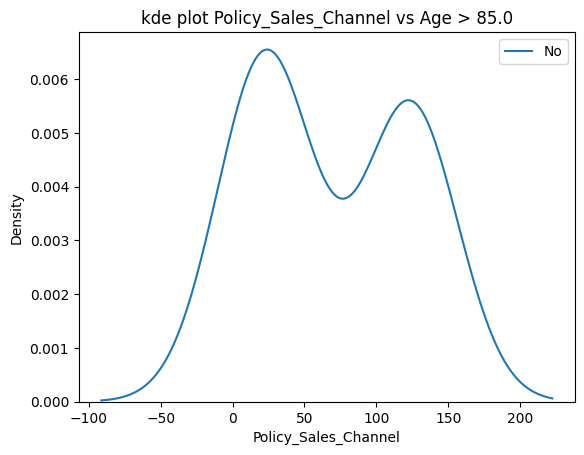

Age Vintage
Q1 : 25.0  Q3 : 49.0  IQR : 24.0 upper_bound : 85.0  lower_bound : -11.0
fig 0.6


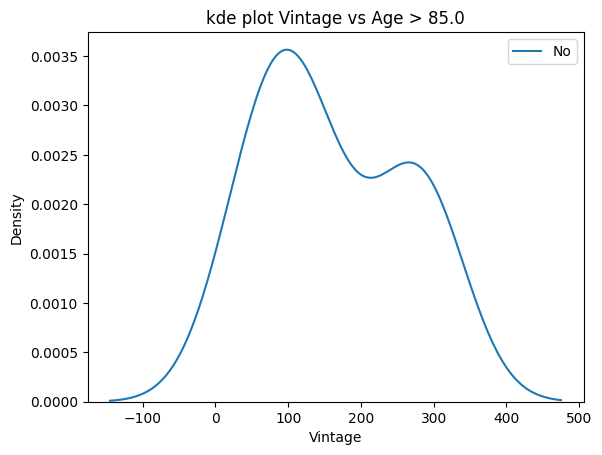

Driving_License Age
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.0


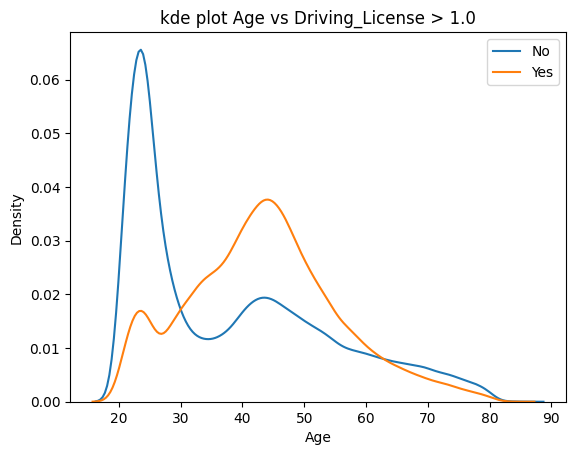

Driving_License Driving_License
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.1


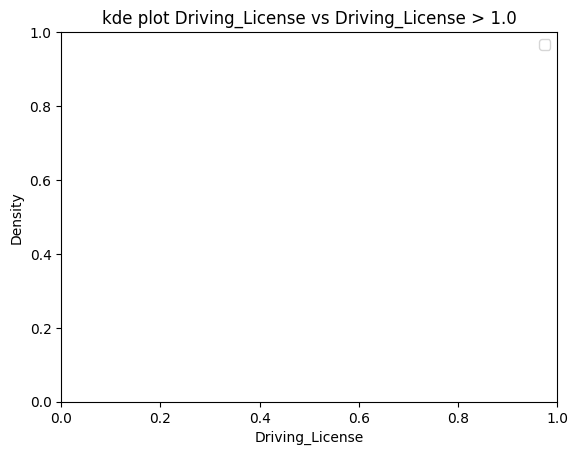

Driving_License Region_Code
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.2


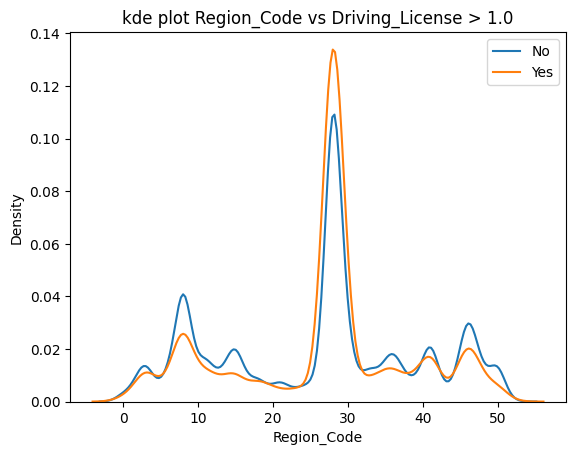

Driving_License Previously_Insured
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.3


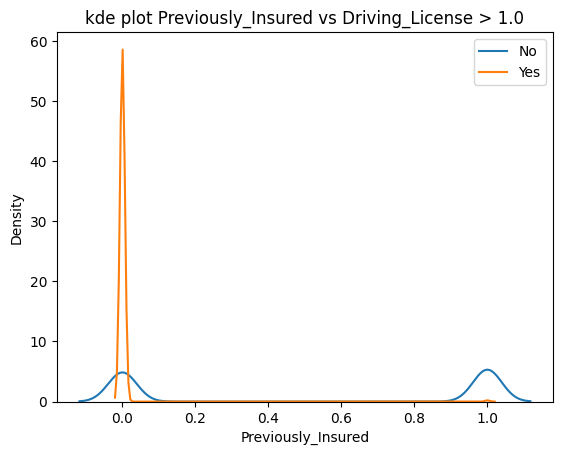

Driving_License Annual_Premium
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.4


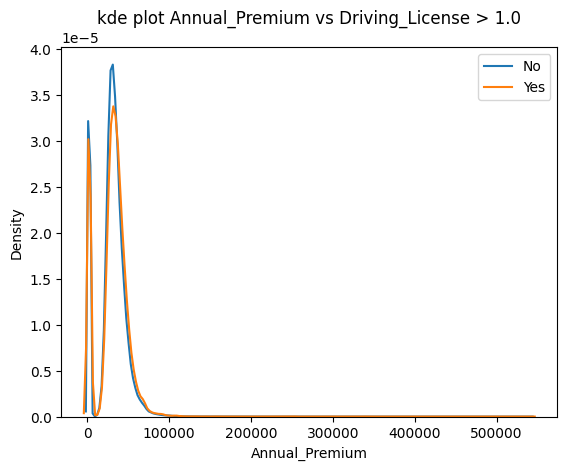

Driving_License Policy_Sales_Channel
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.5


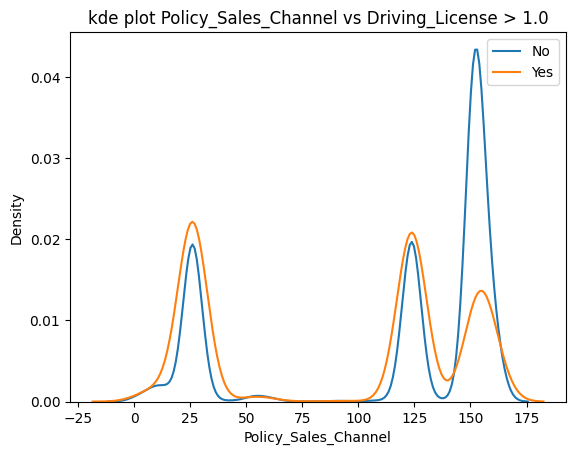

Driving_License Vintage
Q1 : 1.0  Q3 : 1.0  IQR : 0.0 upper_bound : 1.0  lower_bound : 1.0
fig 1.6


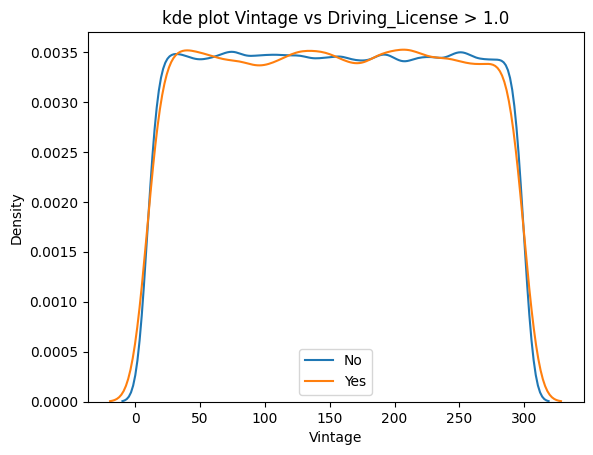

Region_Code Age
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.0


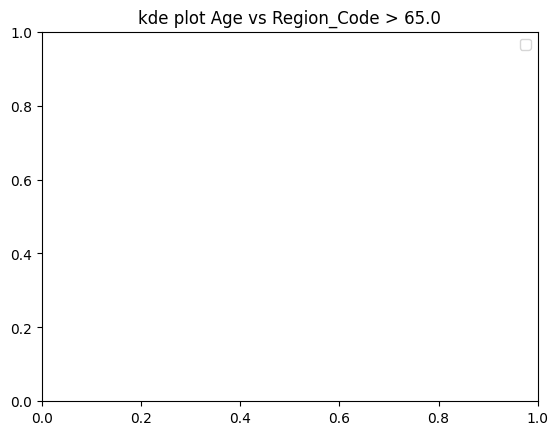

Region_Code Driving_License
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.1


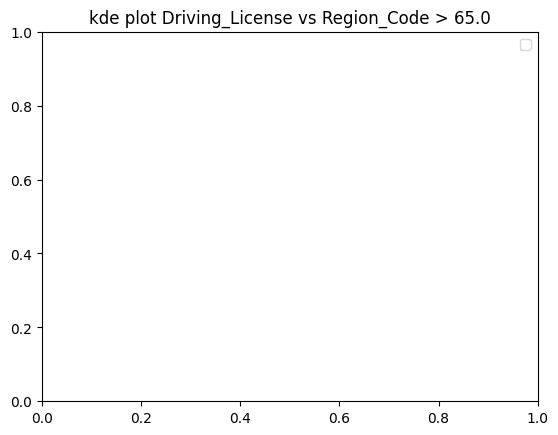

Region_Code Region_Code
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.2


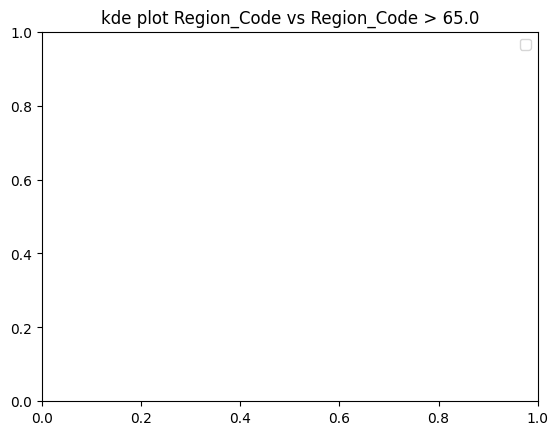

Region_Code Previously_Insured
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.3


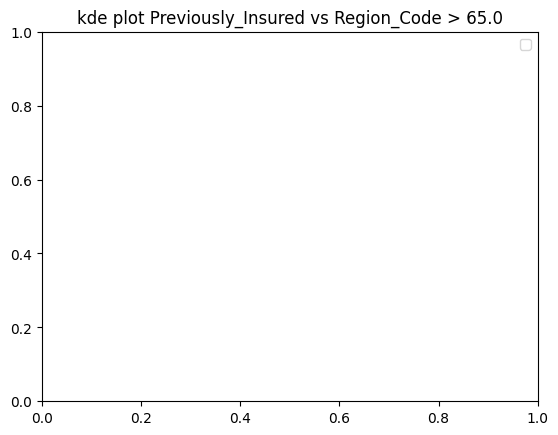

Region_Code Annual_Premium
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.4


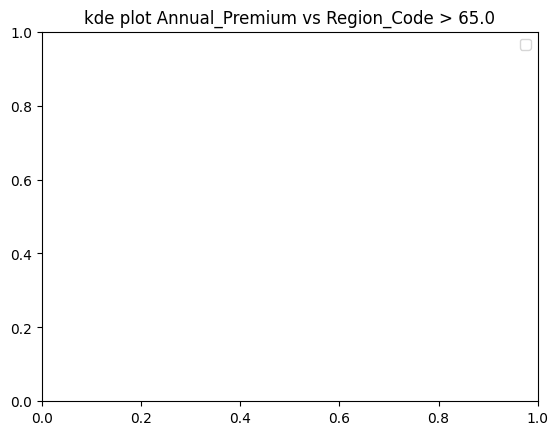

Region_Code Policy_Sales_Channel
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.5


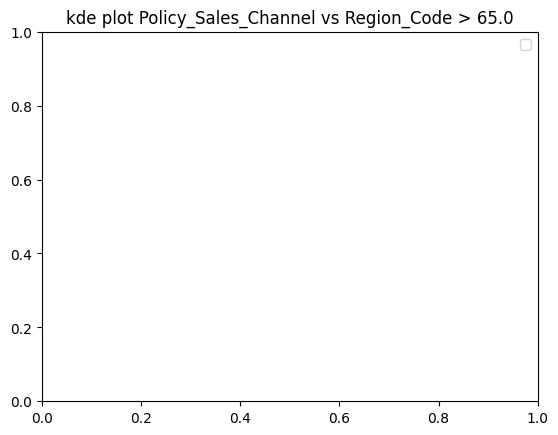

Region_Code Vintage
Q1 : 15.0  Q3 : 35.0  IQR : 20.0 upper_bound : 65.0  lower_bound : -15.0
fig 2.6


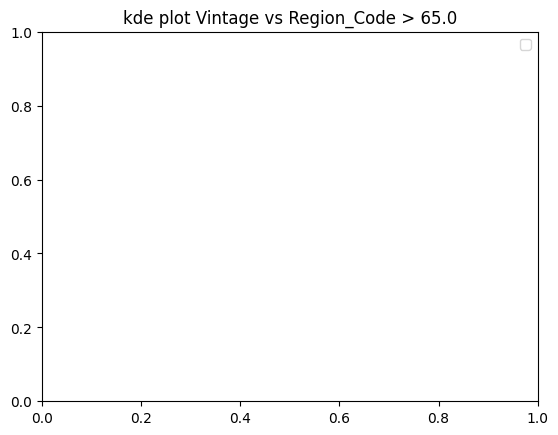

Previously_Insured Age
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.0


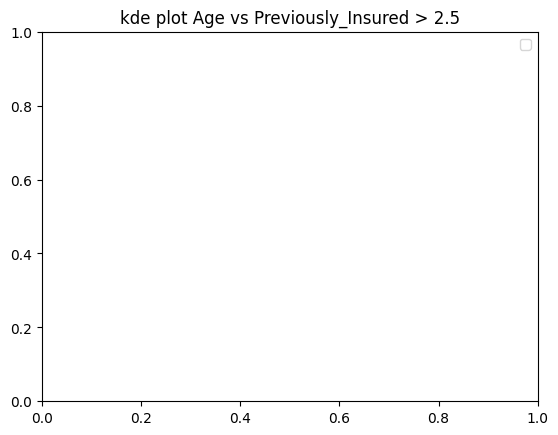

Previously_Insured Driving_License
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.1


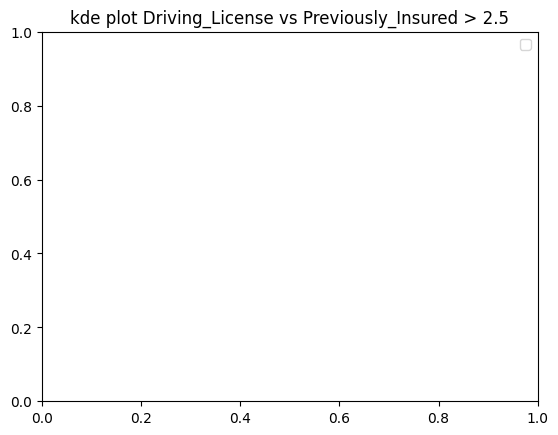

Previously_Insured Region_Code
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.2


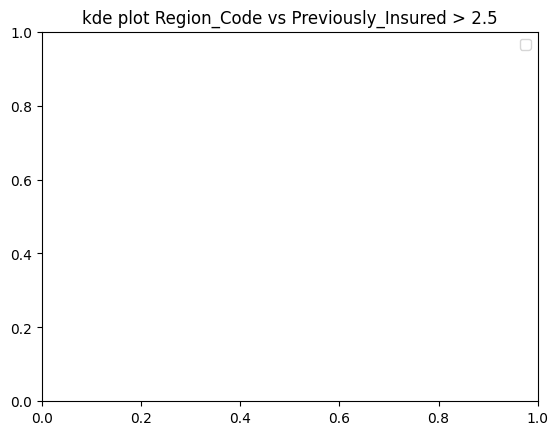

Previously_Insured Previously_Insured
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.3


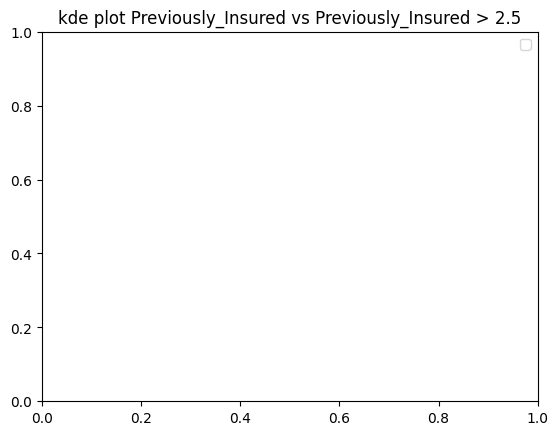

Previously_Insured Annual_Premium
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.4


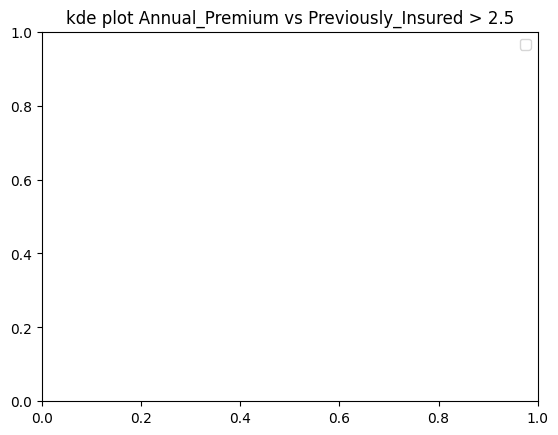

Previously_Insured Policy_Sales_Channel
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.5


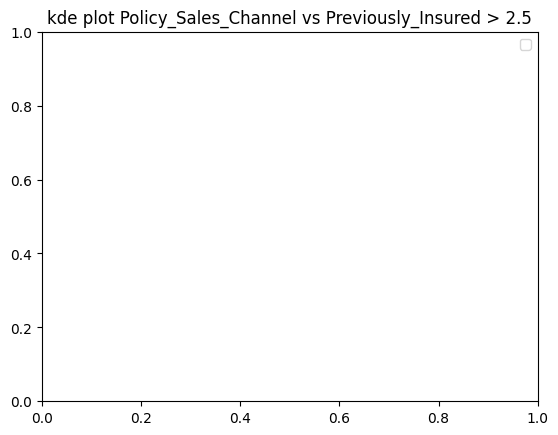

Previously_Insured Vintage
Q1 : 0.0  Q3 : 1.0  IQR : 1.0 upper_bound : 2.5  lower_bound : -1.5
fig 3.6


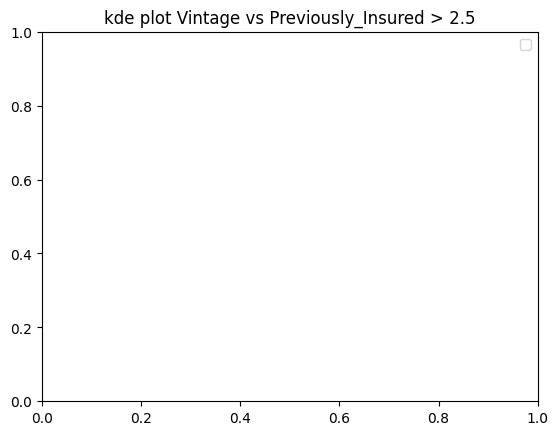

Annual_Premium Age
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.0


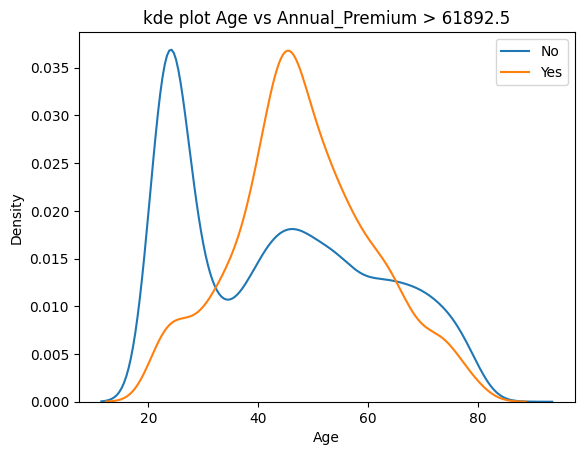

Annual_Premium Driving_License
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.1


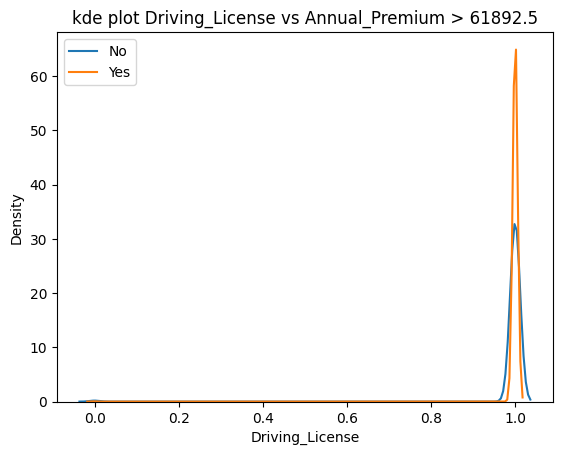

Annual_Premium Region_Code
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.2


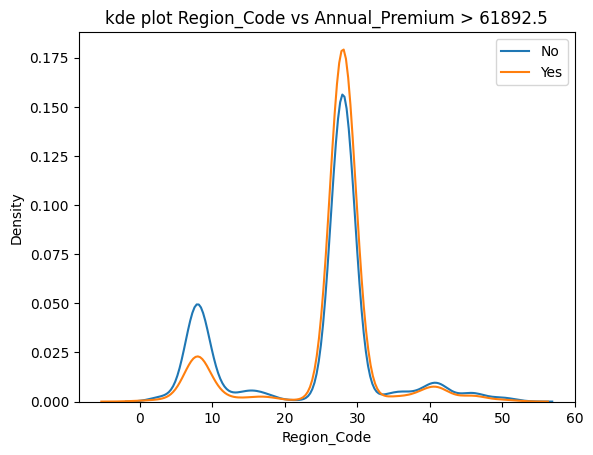

Annual_Premium Previously_Insured
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.3


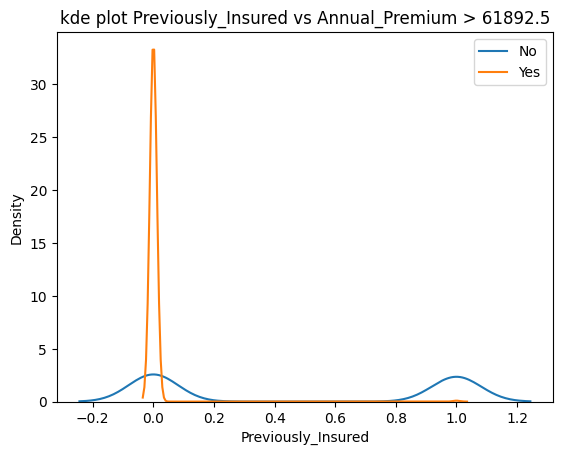

Annual_Premium Annual_Premium
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.4


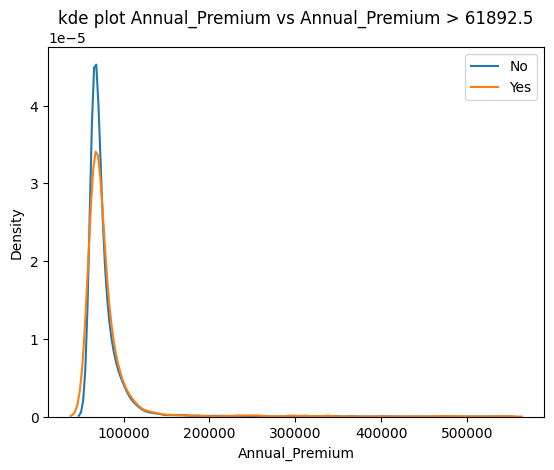

Annual_Premium Policy_Sales_Channel
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.5


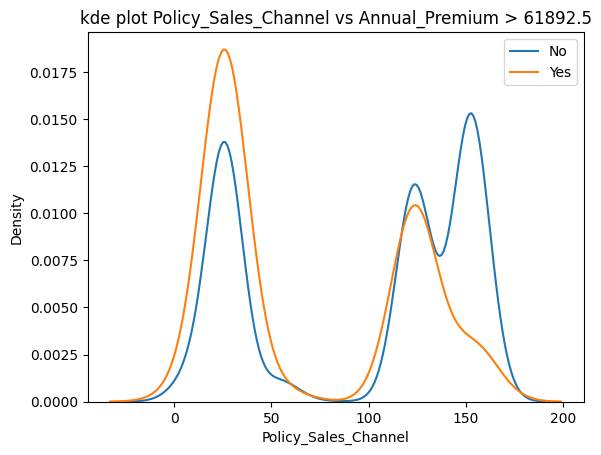

Annual_Premium Vintage
Q1 : 24405.0  Q3 : 39400.0  IQR : 14995.0 upper_bound : 61892.5  lower_bound : 1912.5
fig 4.6


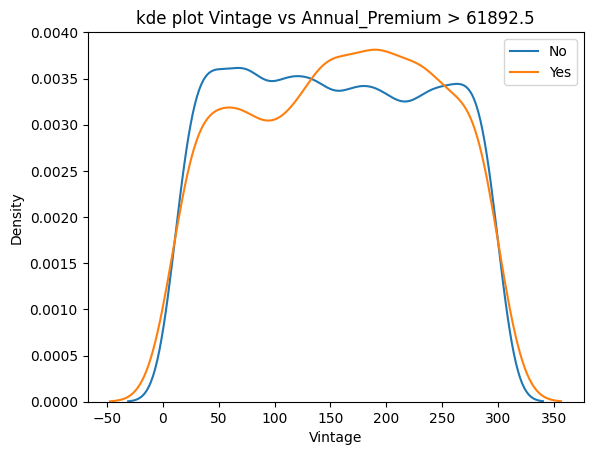

Policy_Sales_Channel Age
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.0


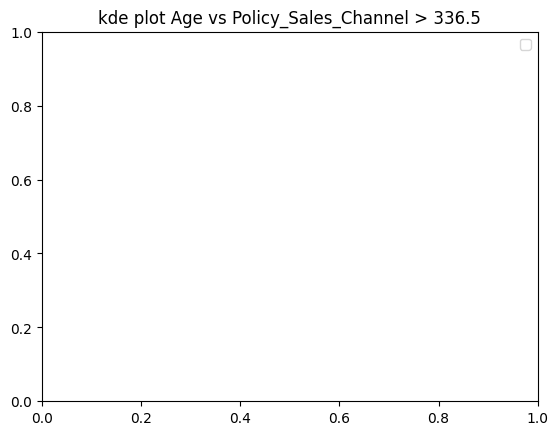

Policy_Sales_Channel Driving_License
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.1


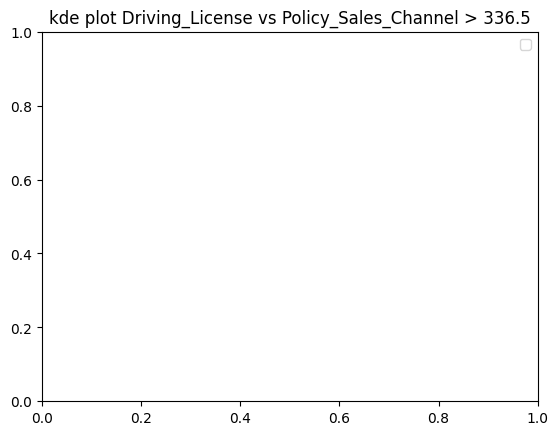

Policy_Sales_Channel Region_Code
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.2


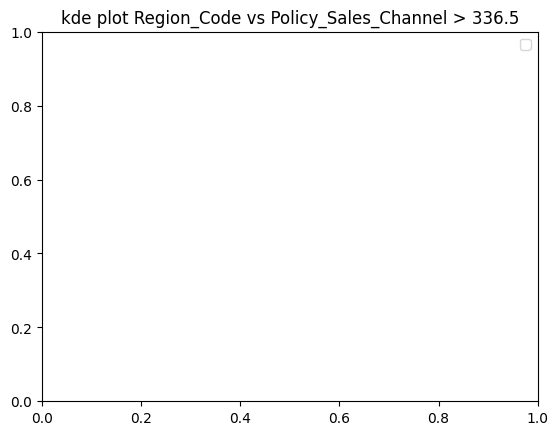

Policy_Sales_Channel Previously_Insured
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.3


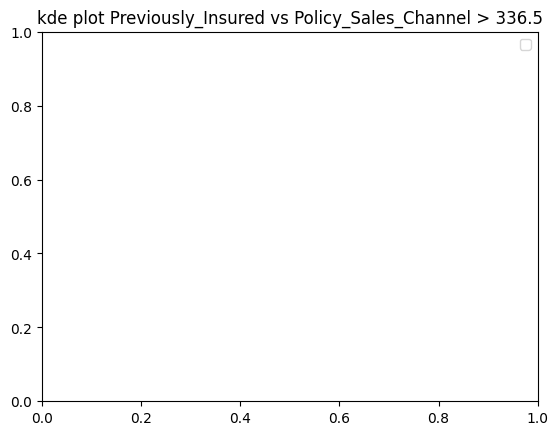

Policy_Sales_Channel Annual_Premium
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.4


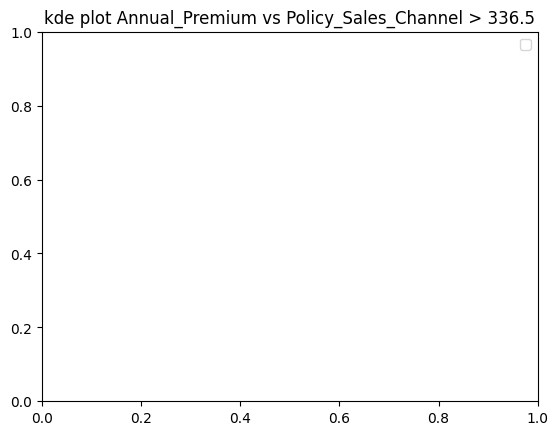

Policy_Sales_Channel Policy_Sales_Channel
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.5


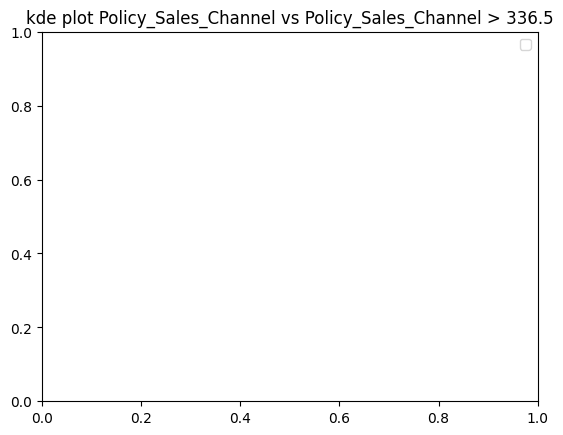

Policy_Sales_Channel Vintage
Q1 : 29.0  Q3 : 152.0  IQR : 123.0 upper_bound : 336.5  lower_bound : -155.5
fig 5.6


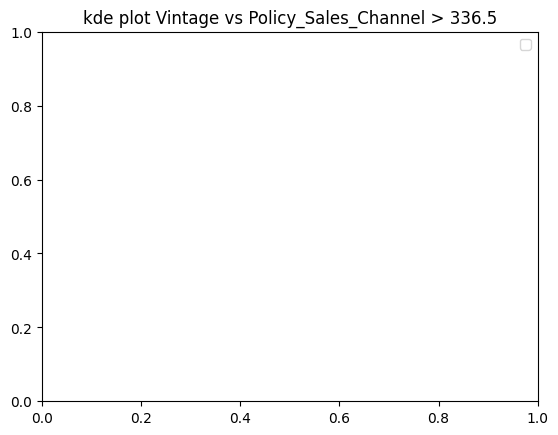

Vintage Age
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.0


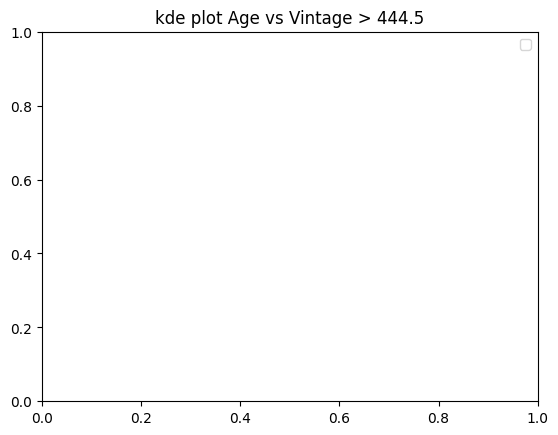

Vintage Driving_License
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.1


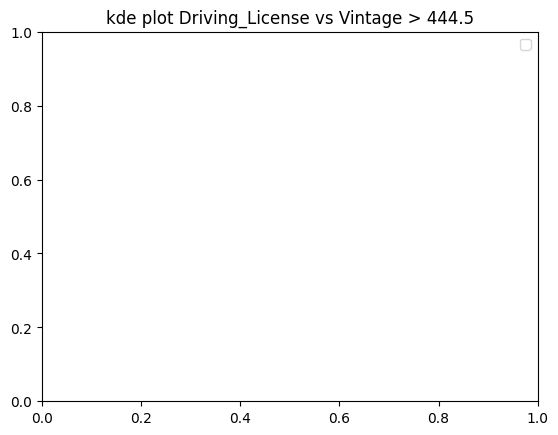

Vintage Region_Code
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.2


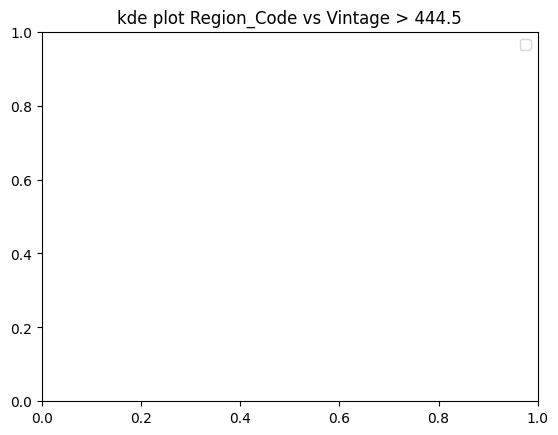

Vintage Previously_Insured
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.3


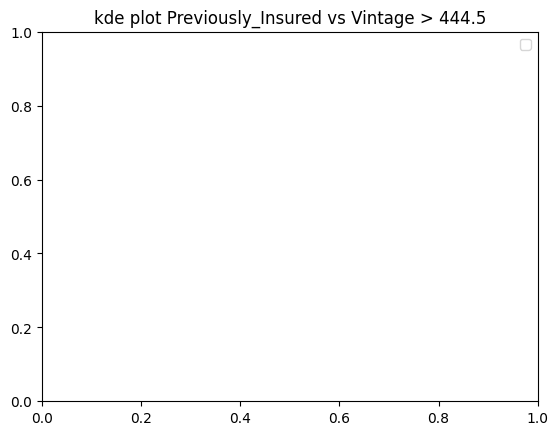

Vintage Annual_Premium
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.4


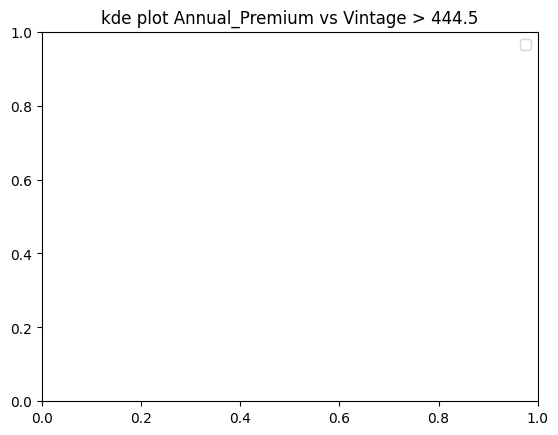

Vintage Policy_Sales_Channel
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.5


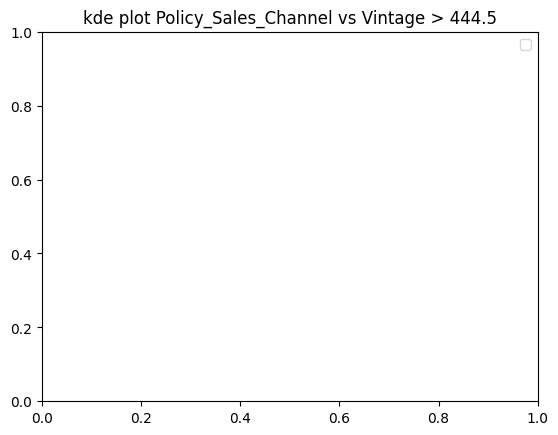

Vintage Vintage
Q1 : 82.0  Q3 : 227.0  IQR : 145.0 upper_bound : 444.5  lower_bound : -135.5
fig 6.6


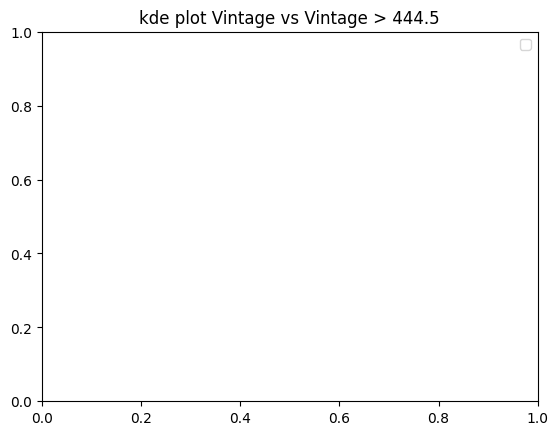

In [22]:
# Checking the outliers in all feature based on the target column and does it affext in some to our target column.  
# figure out is there any relation in terms of outlier values and the target column
# objective is to decide wheather to remove to oulier or we are getting any insites.
# fig 1.2
for i,left_feature in enumerate(numeric_features):
  for j,right_feature in enumerate(numeric_features):
    Q1,Q3,IQR,upper_bound,lower_bound = getsummary(left_feature)
    print(left_feature,right_feature)
    print('Q1 :',Q1,' Q3 :',Q3,' IQR :',IQR,'upper_bound :',upper_bound,' lower_bound :',lower_bound)
    print(f'fig {i}.{j}')
    sns.kdeplot(df[(df[left_feature] >= upper_bound) & (df['Response'] == 0)][right_feature])
    sns.kdeplot(df[(df[left_feature] >= upper_bound) & (df['Response'] == 1)][right_feature])
    plt.legend(labels=["No","Yes"])
    # displaying the title
    plt.title(f"kde plot {right_feature} vs {left_feature} > {upper_bound}")
    plt.show ()

#### Observation 
  
  - `Age`
    - Above upper bound the `Driving_License` for both 0 or 1 showing no interent in vehicle insurance (fig 0.1) 
    - Same responce = 0 means no interest in vehicle insurance for `Previous_isure`, `Annual_Premium`, `Policy_sales_channel`,`vintage` fig (0.2 - 0.6) 
    - `Age` in range `18 - 35` and `Annual premium > 61892.5` not interested in Vehicle Insurance.
    - where as `Age` in range `35 - 75` and `Annual premium > 61892.5` are showing more interested in Vehicle Insurance. fig(4.0)
    - `Age` in range `32 to 65` with `Driving Licence` shows interest in vehicle insaurance fig(4.0)
    - `Age` in range `18 to 30` with `Driving Licence` not interested in Vehicle Insurance.

  - `Drivinf_License`
    -  `Driving_License` is 1 and and `Annual premium > 61892.5` shows interested in Vehicle Insurance. fig(4.1)
  
  - `Region_Code` 
    - `Region_Code ` in range `25 - 32` with `Driving_License` shows interested in Vehicle Insurance. fig (1.2)
    -  `Region_Code` is range `0 - 20` and and `Annual premium > 61892.5` shows no interested in Vehicle Insurance. fig(4.2)   
    -  `Region_Code` is range `20 - 35` and and `Annual premium > 61892.5` shows interested in Vehicle Insurance. fig(4.2)
  
  - `Previously_Insured`
    - `Previously_Insured` is yes with `Driving_License` shows interested in Vehicle Insurance. fig (1.3)
    -  `Previously_Insured` is yes and and `Annual premium > 61892.5` shows interested in Vehicle Insurance.    
    - So we can target those customer who have `Previously_Insured` and `Annual premium > 61892.5` fig(4.3)
  
  - `Policy_Sales_Channel `
    - `Policy_Sales_Channel` with `Driving_License` most likely interested in Vehicle Insurance.  fig(1.5)
    -  `Policy_Sales_Channel` is `range 0 - 55` and and `Annual premium > 61892.5` shows interested in Vehicle Insurance. fig(4.5)
  
  - `Vintage`
    -  `Vintage` is `range 150 - 280` and and `Annual premium > 61892.5` shows interested in Vehicle Insurance. fig(4.6)  

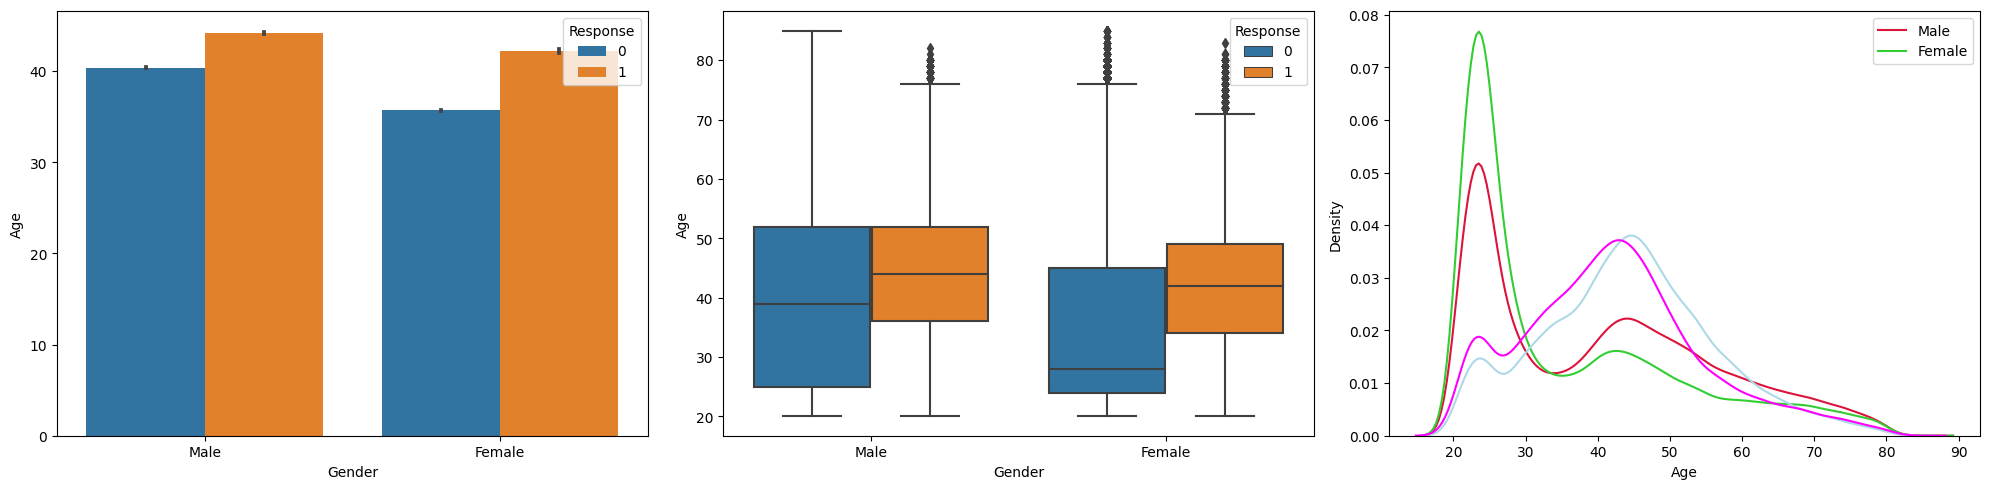

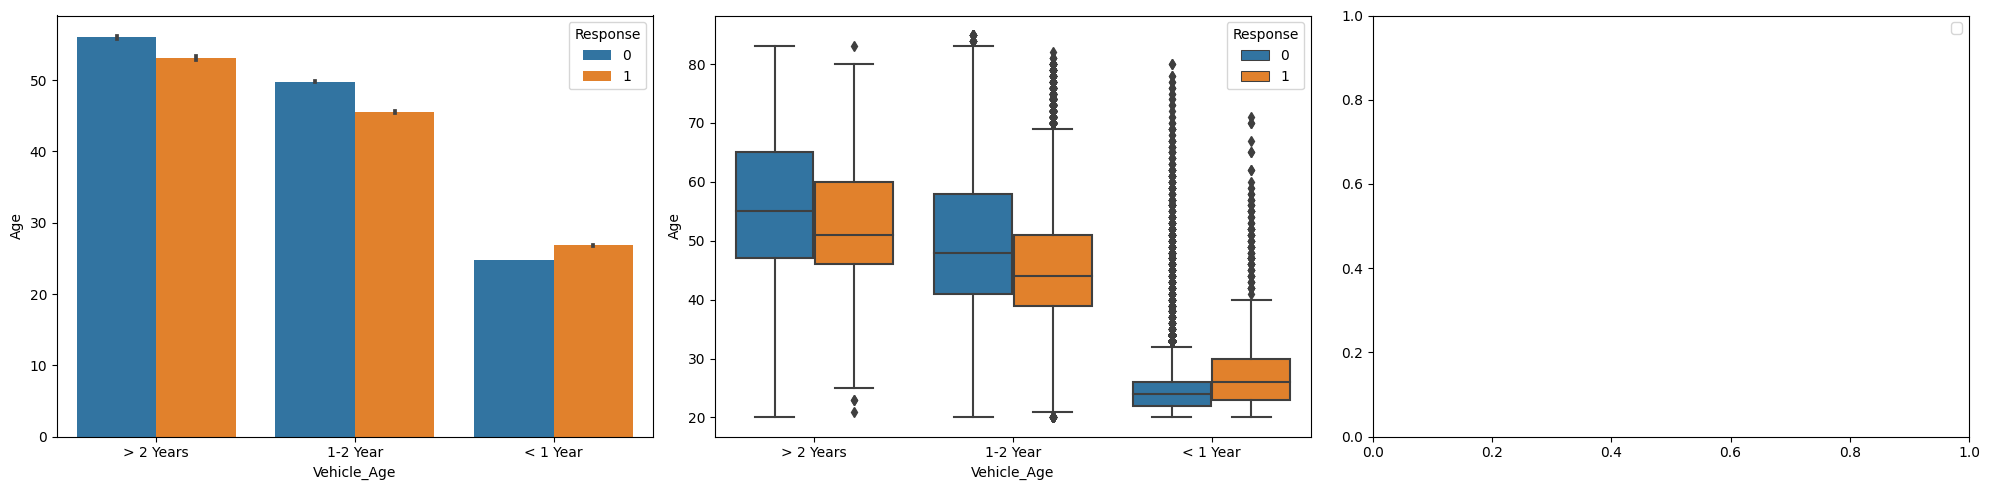

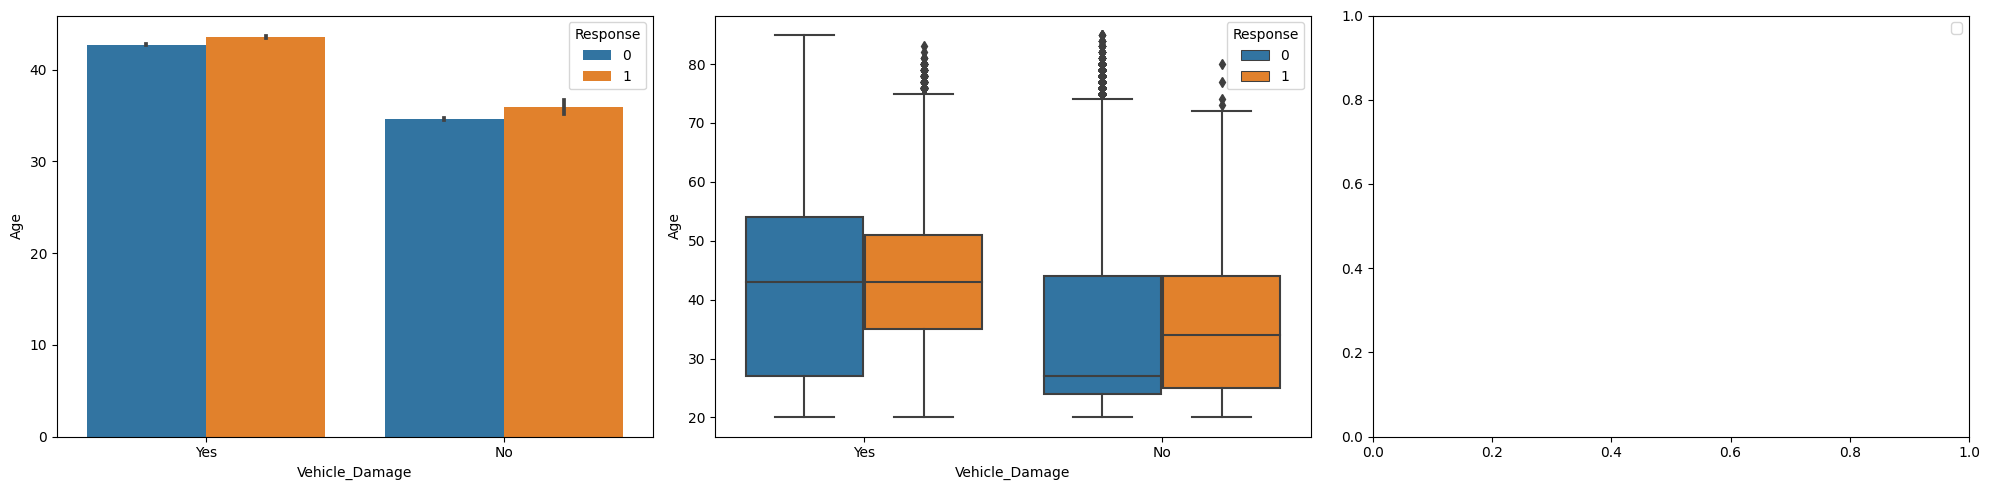

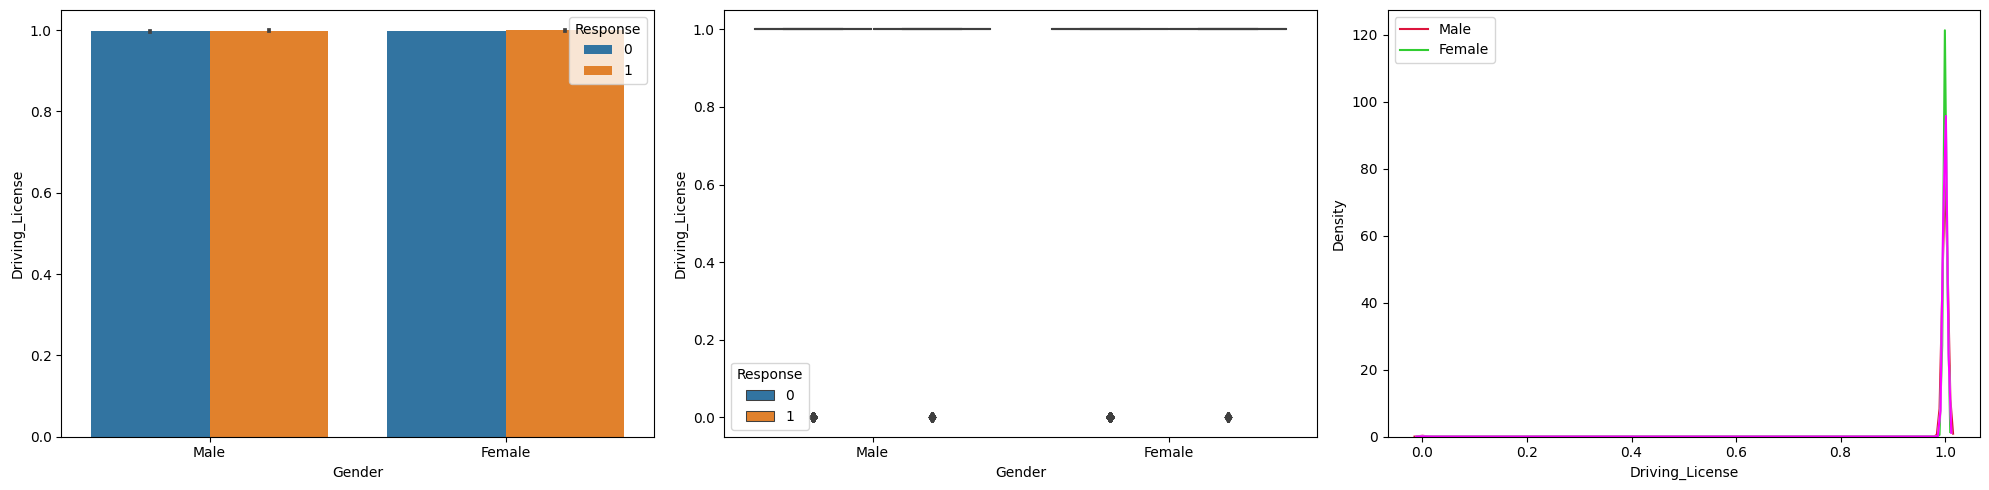

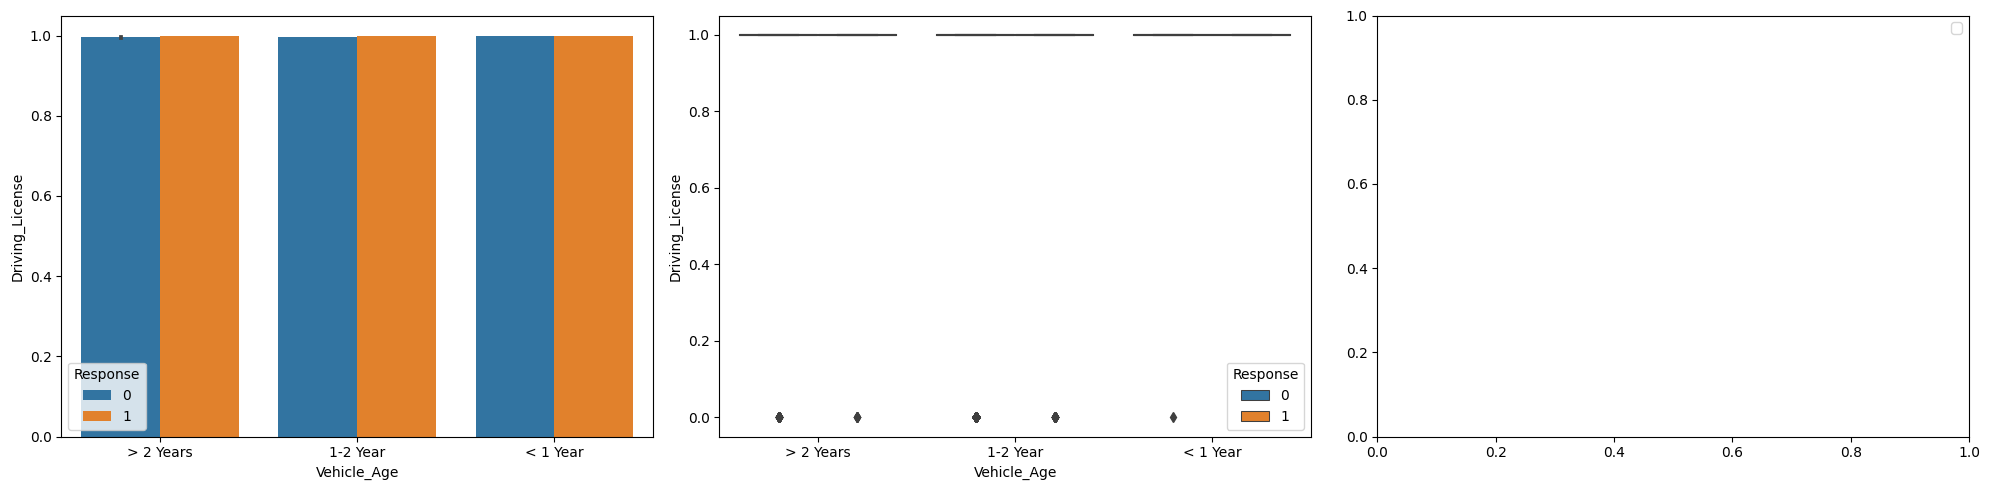

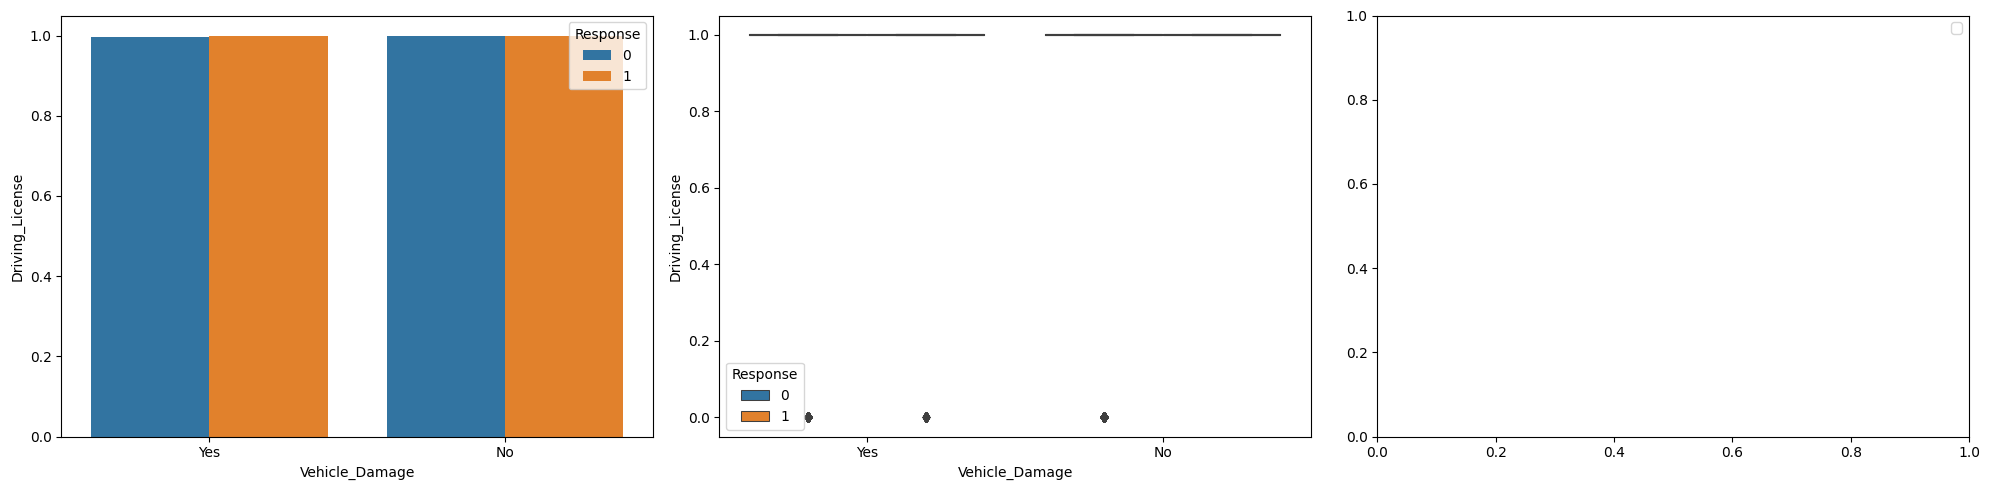

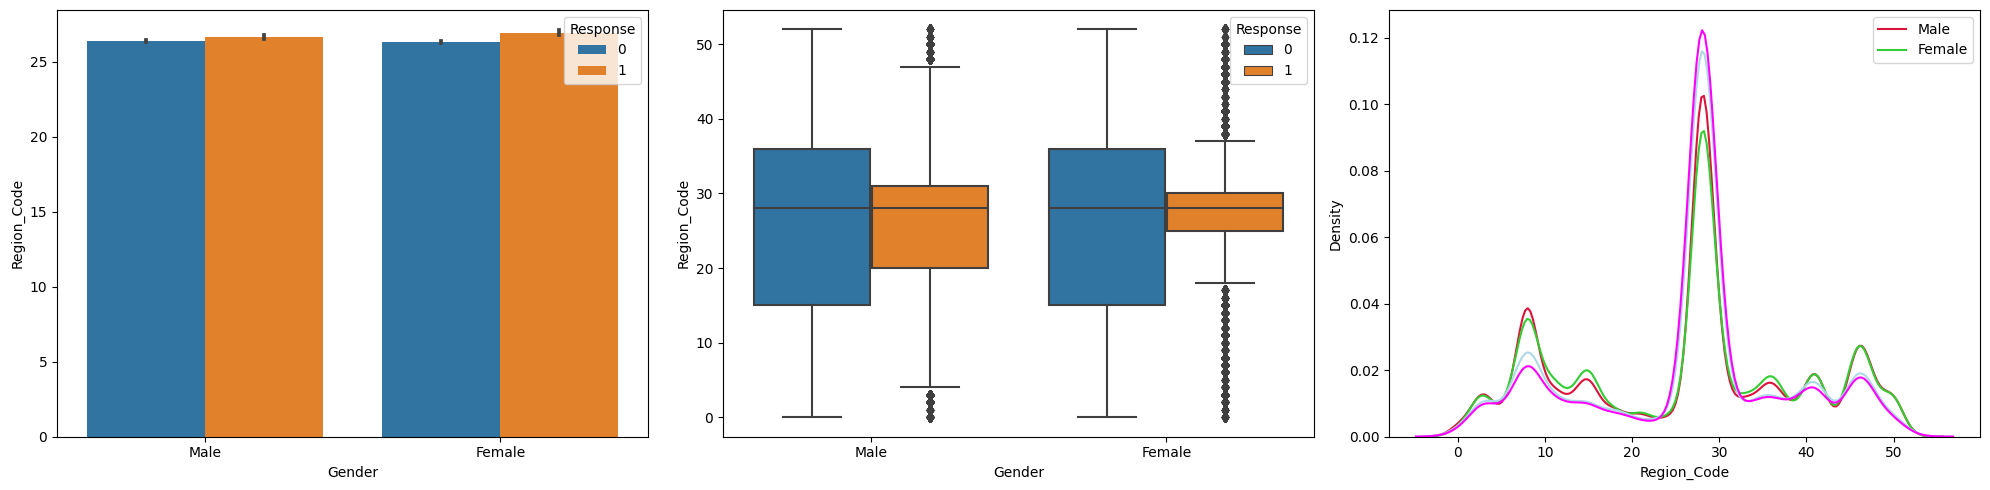

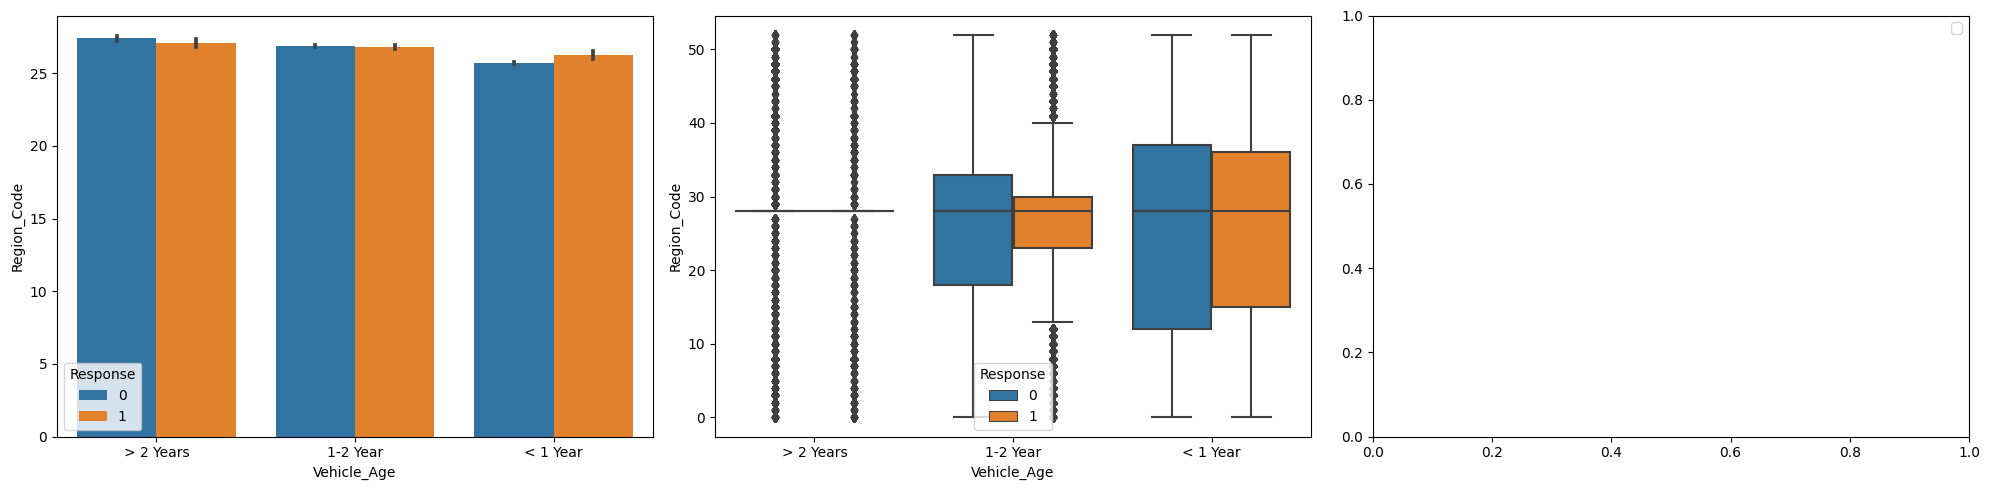

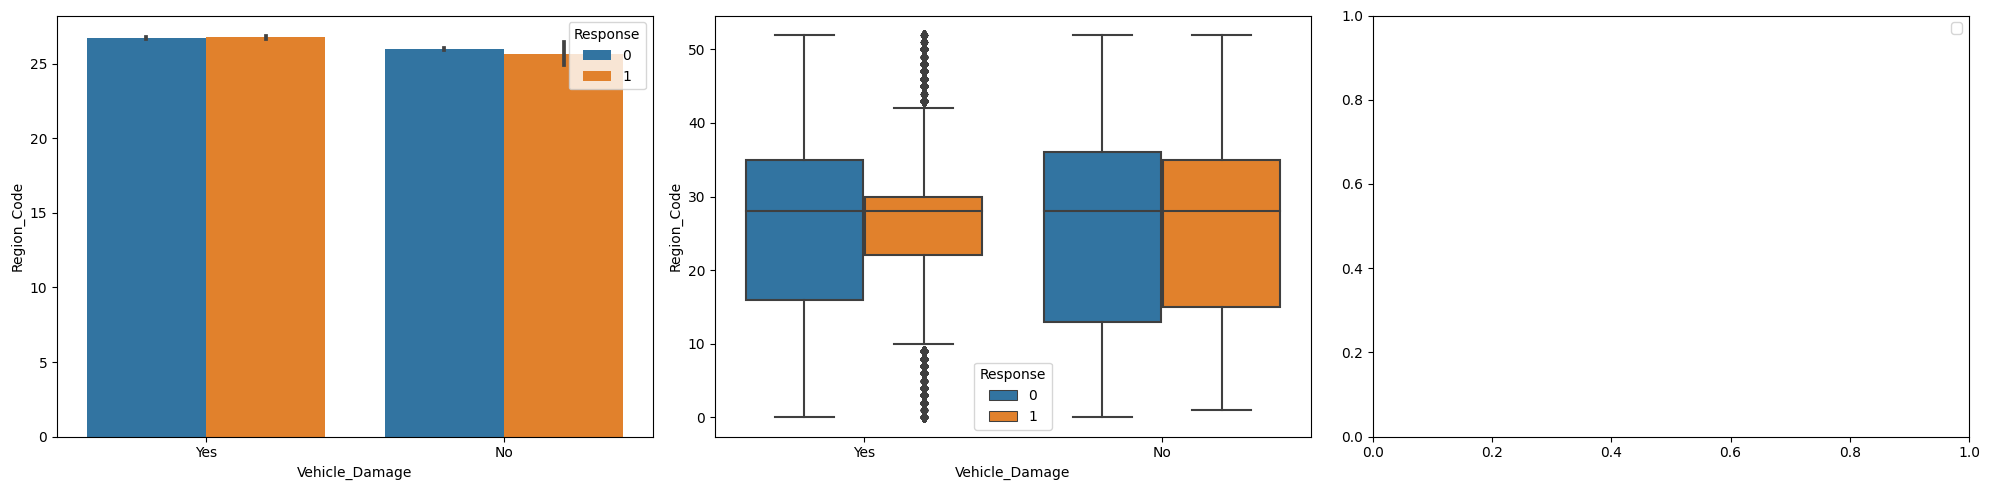

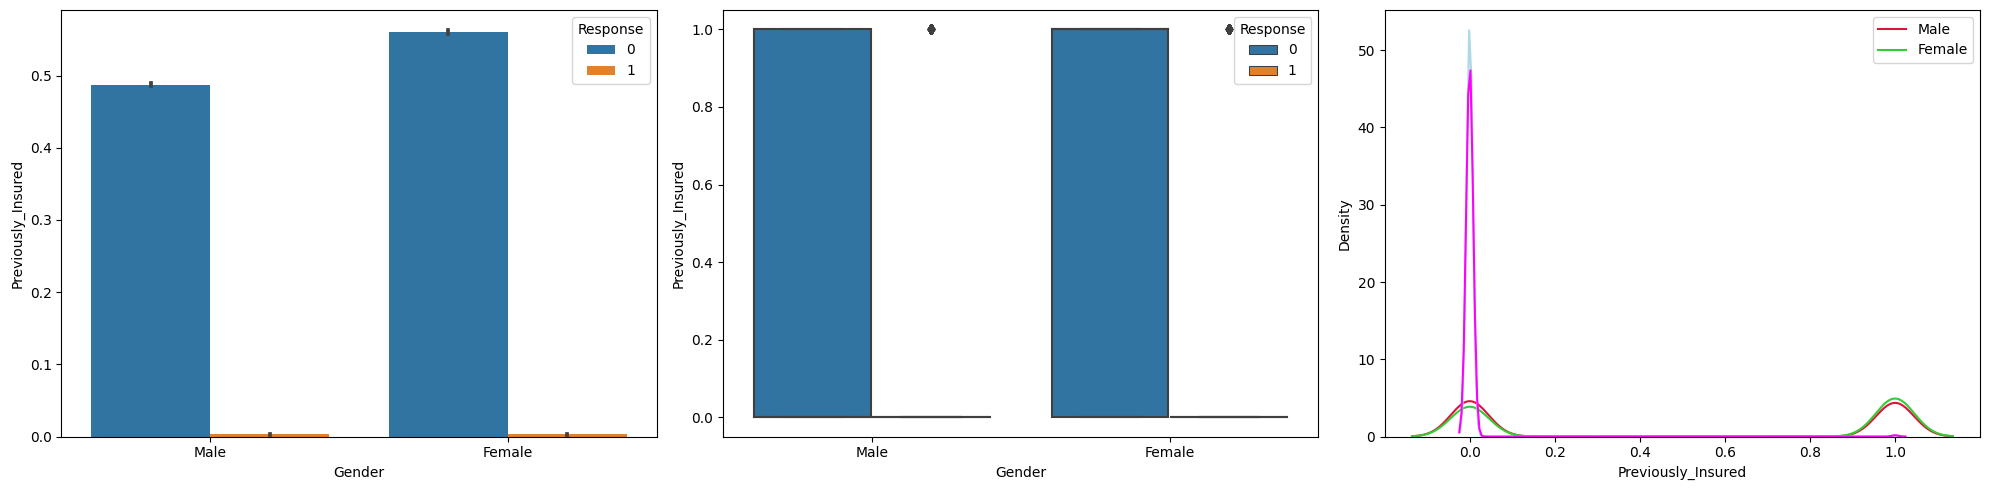

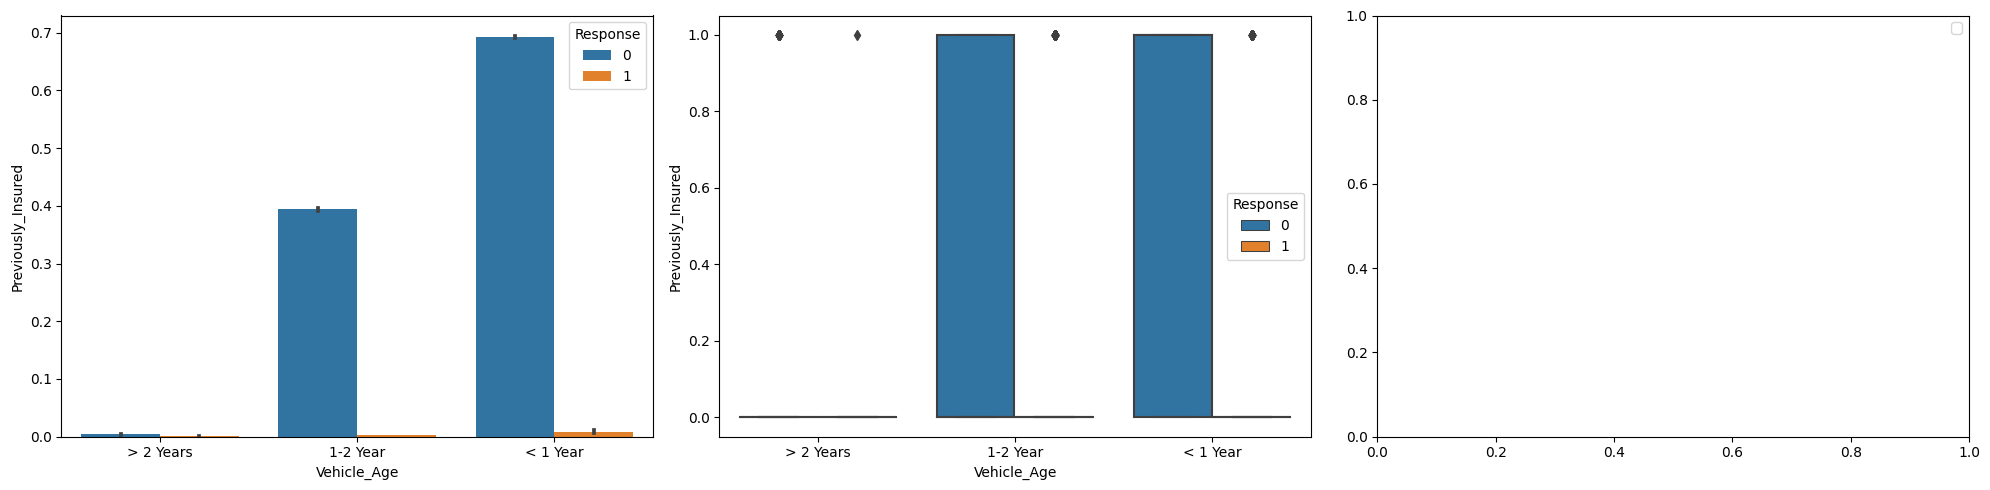

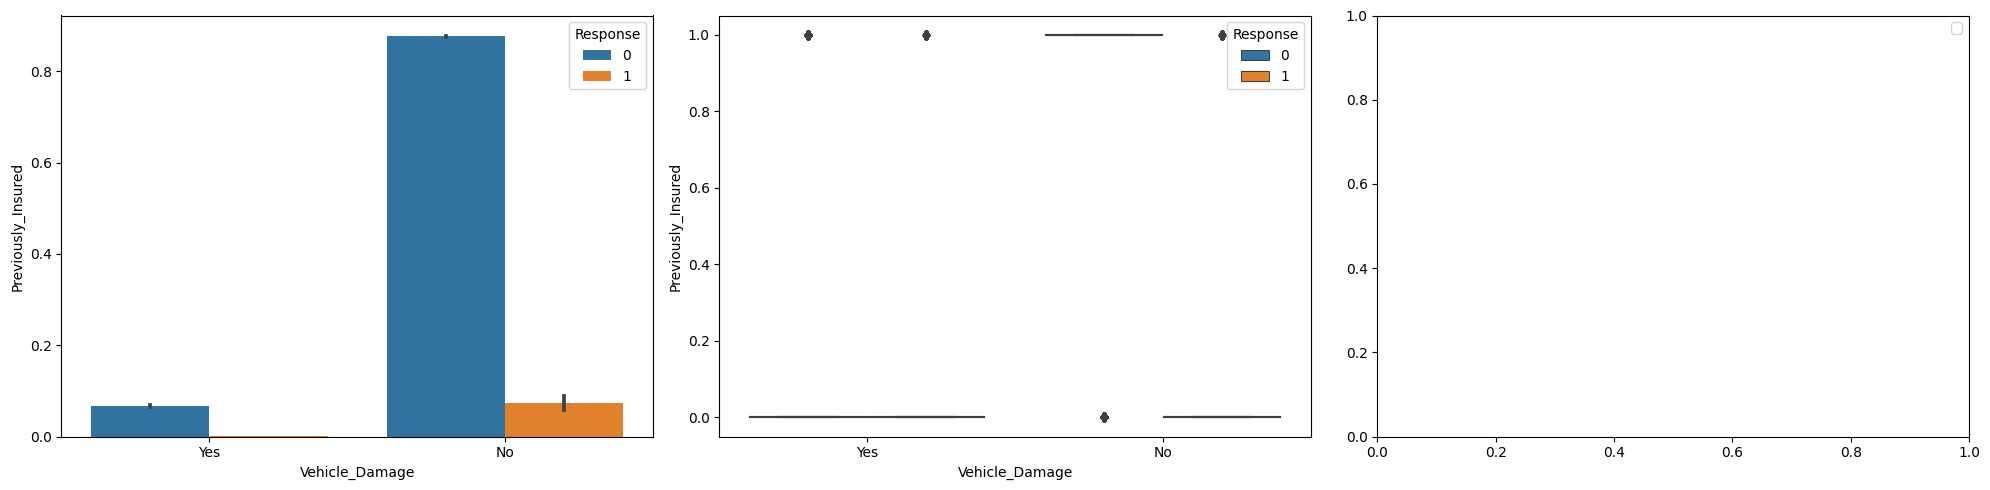

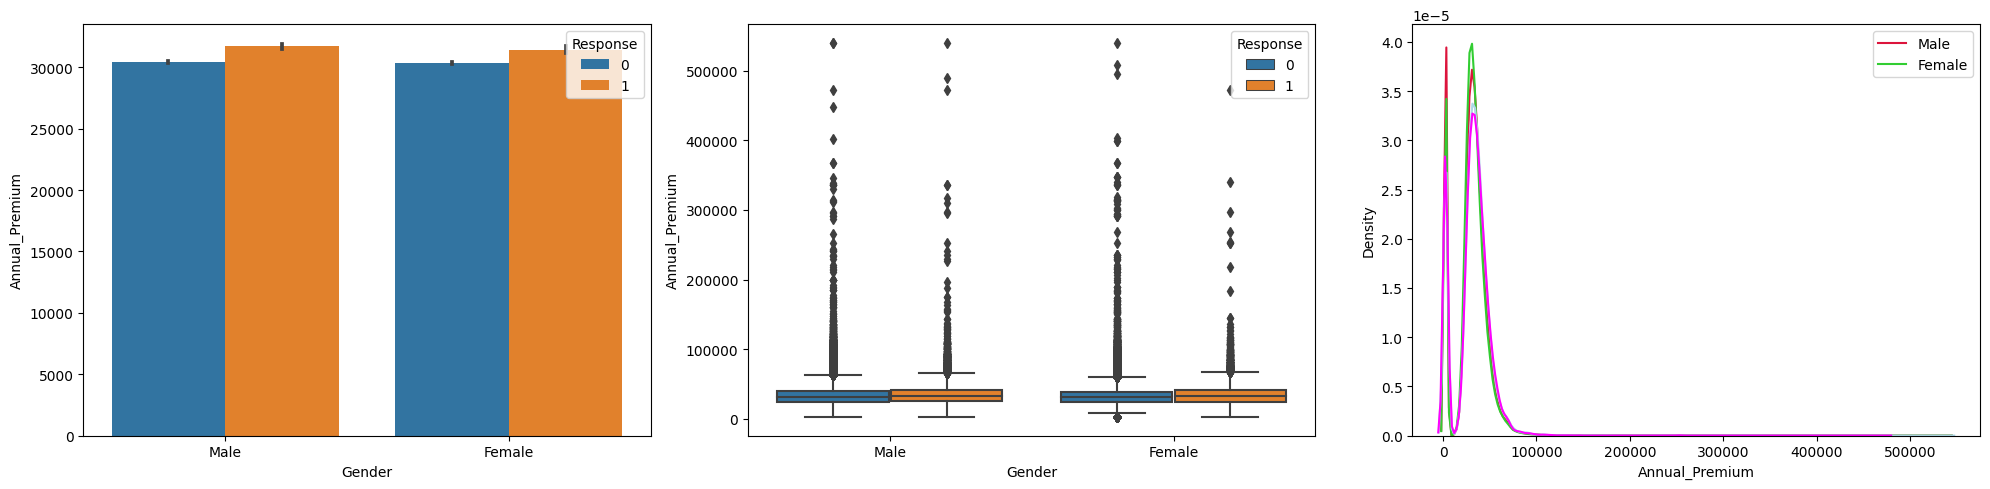

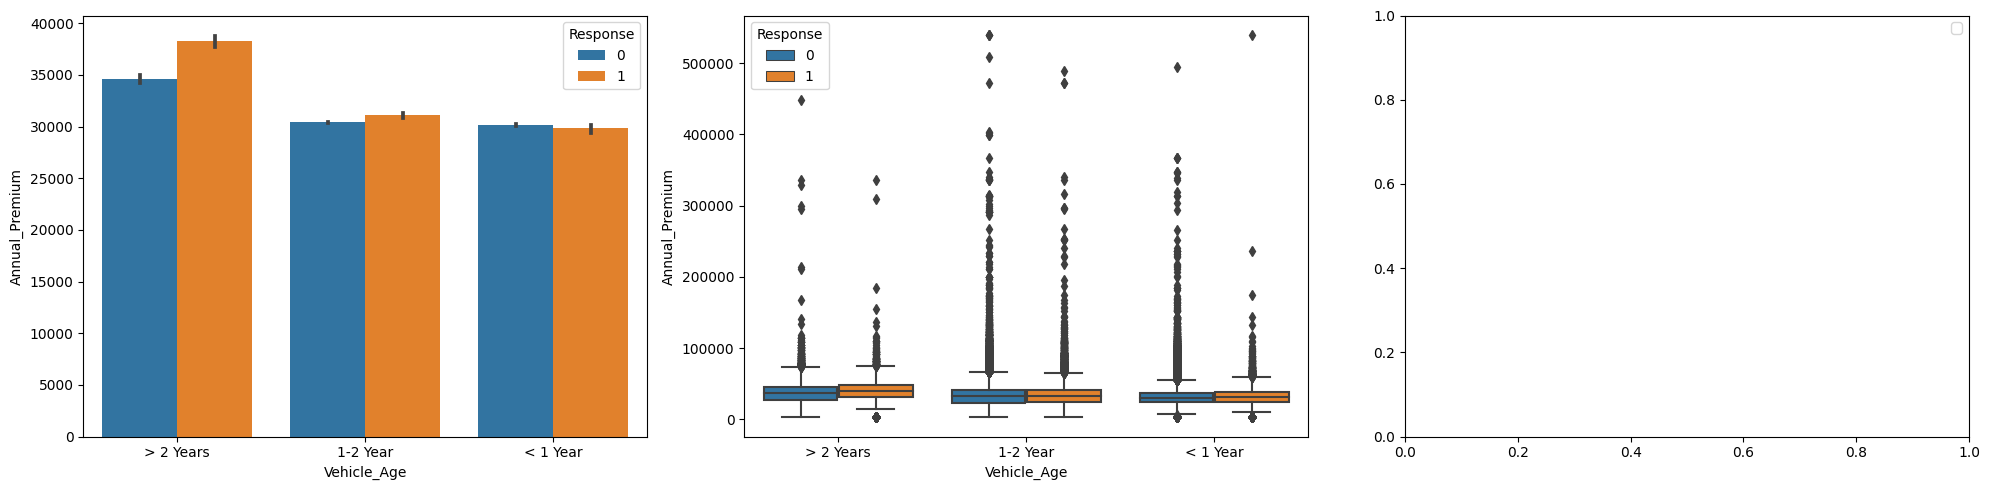

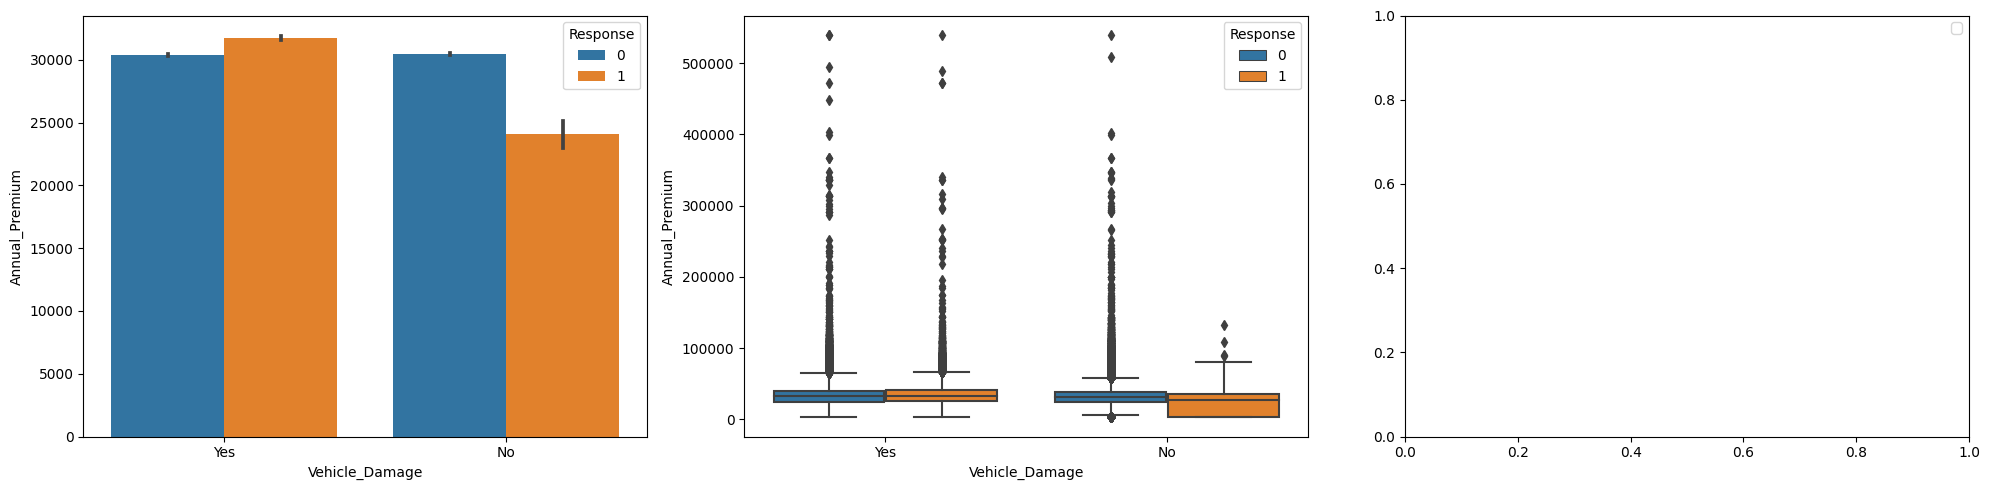

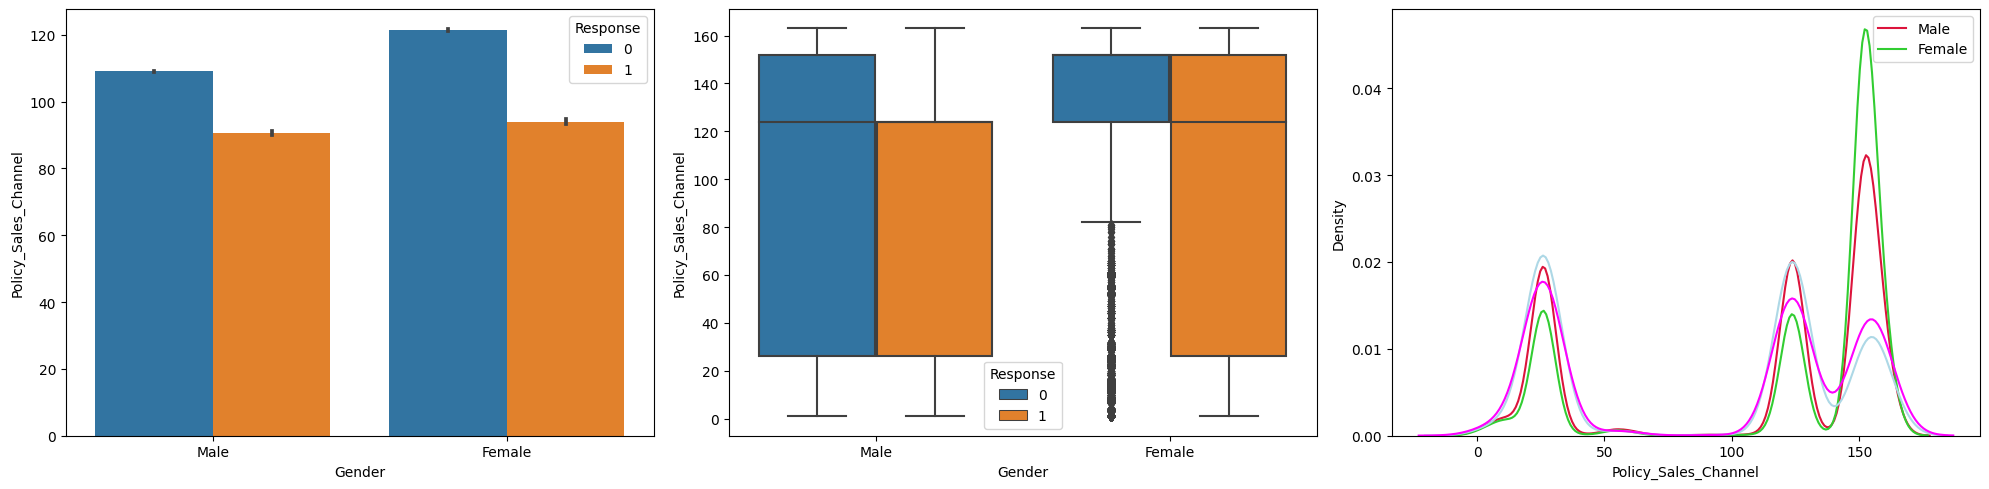

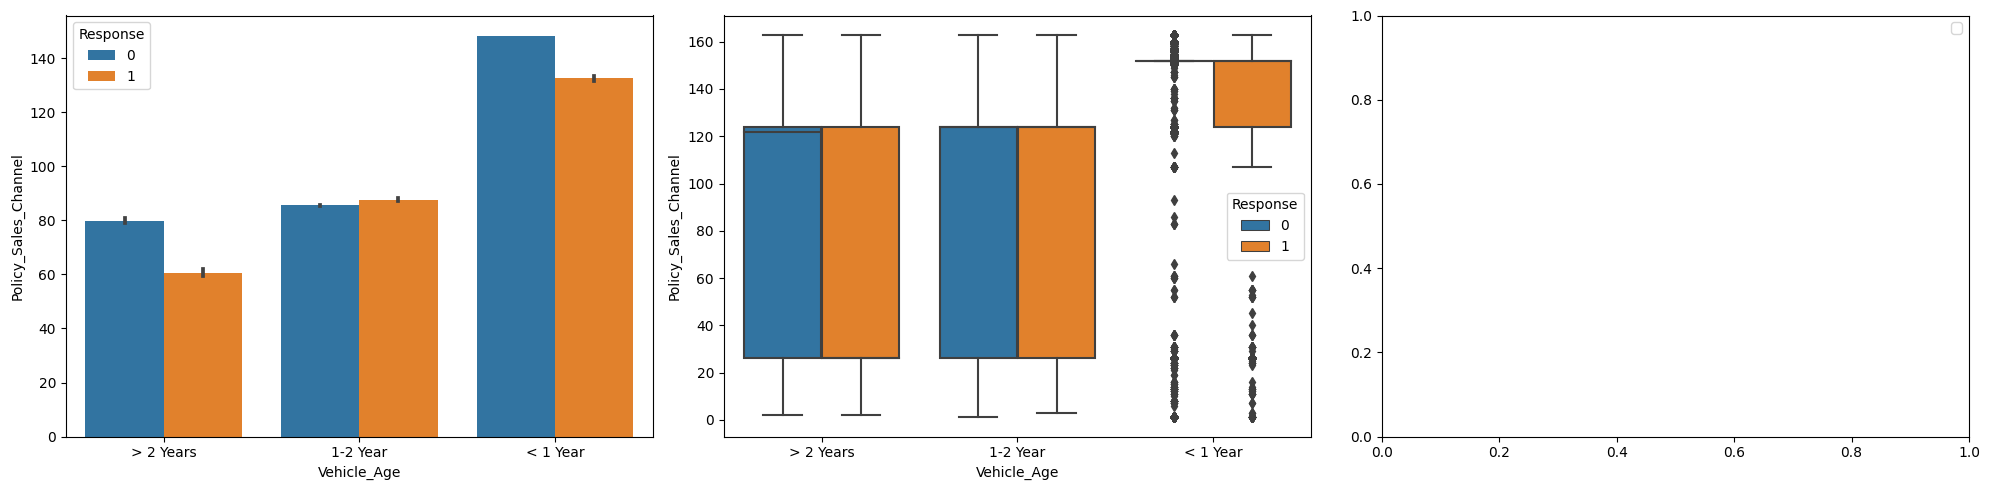

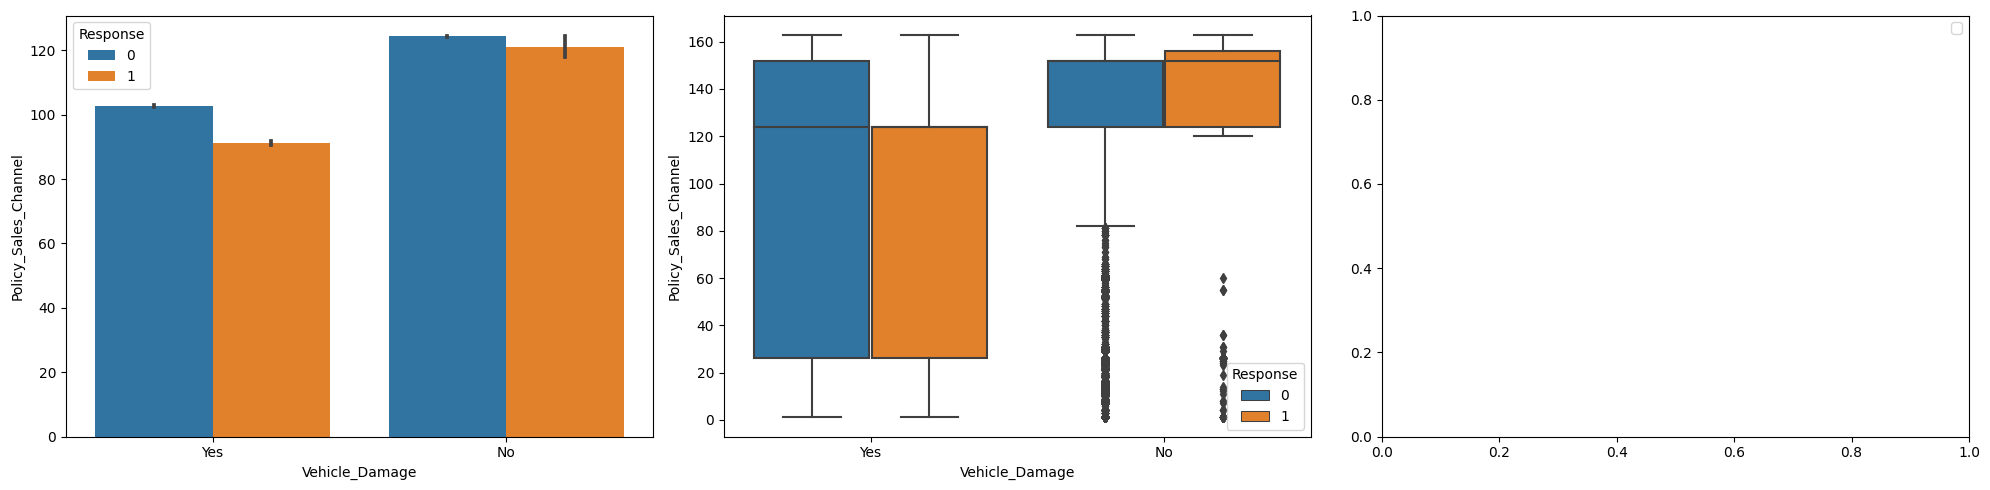

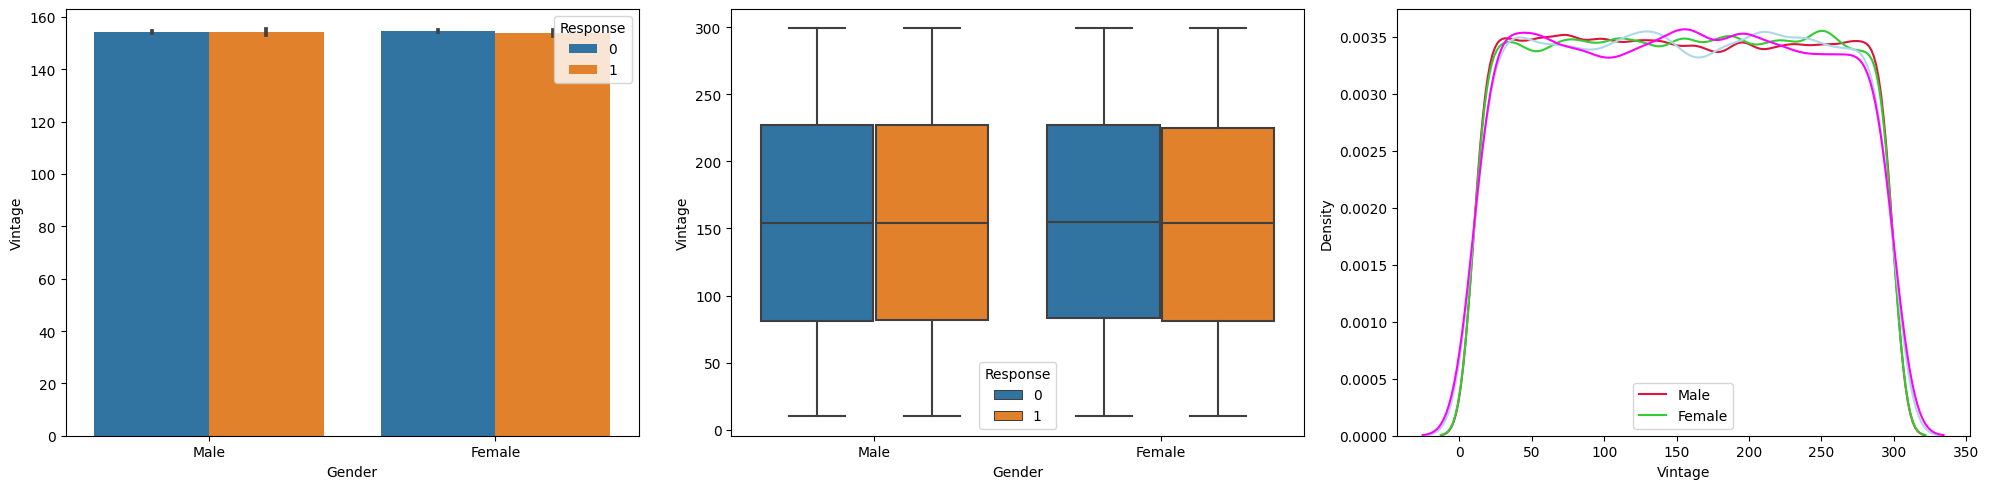

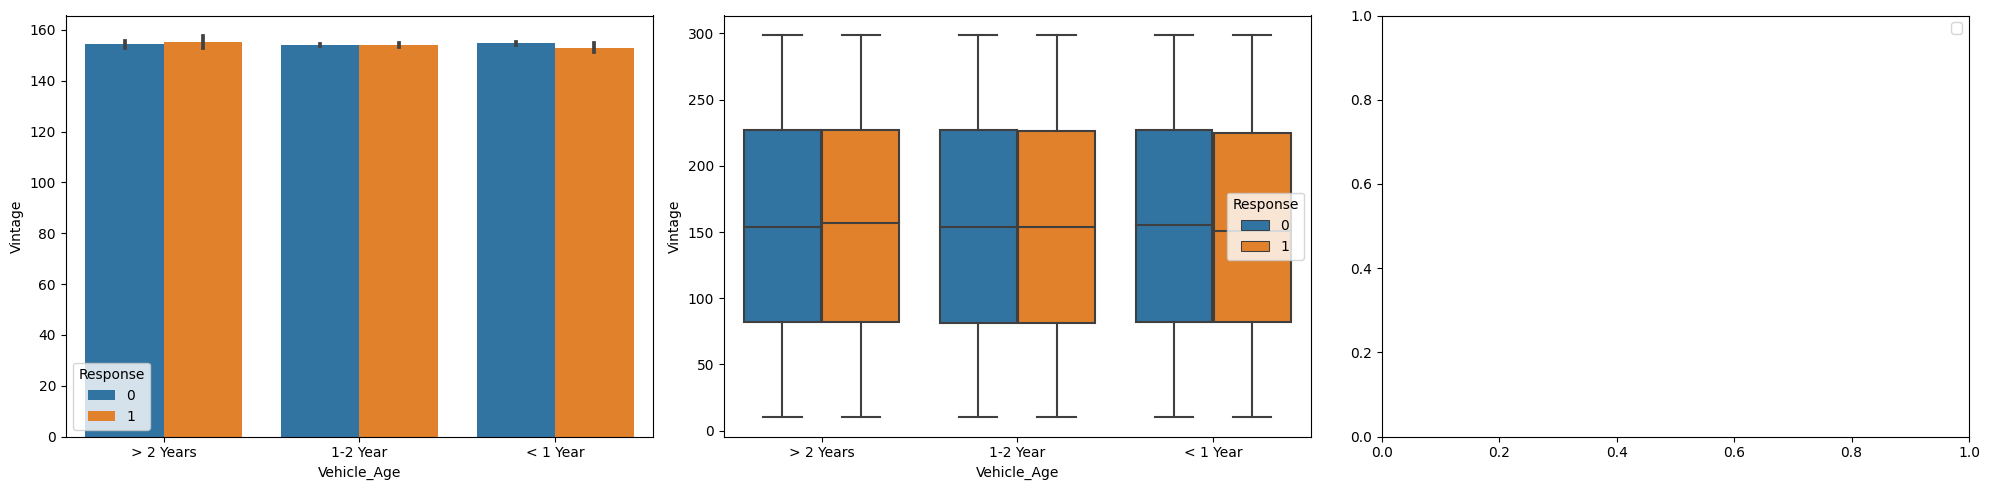

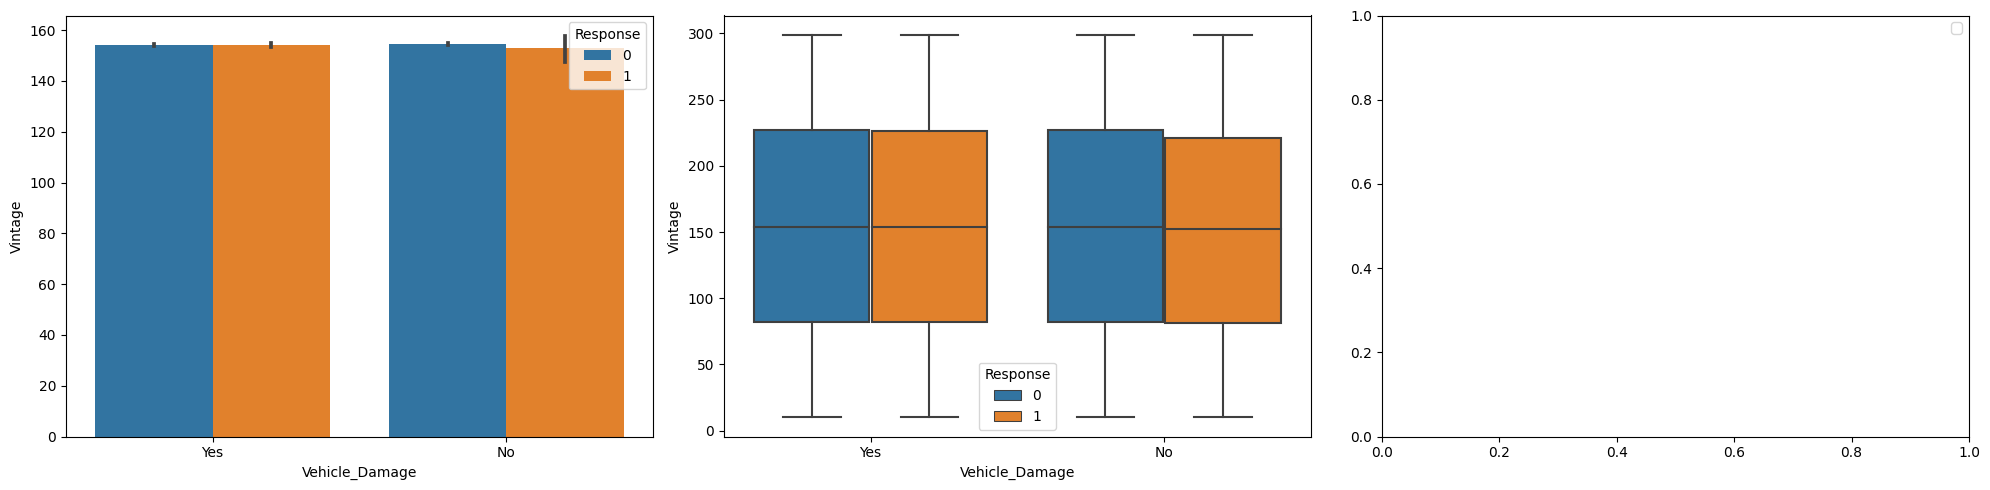

In [23]:
for num_feature in numeric_features:
  for cat_feature in categorical_features:
    fig, ax = plt.subplots(1,3,figsize=(20, 5))
    sns.barplot(data=df,x=df[cat_feature],y=df[num_feature],hue=df[target],ax=ax[0])
    sns.boxplot(data=df,x=df[cat_feature],y=df[num_feature],hue=df[target],ax=ax[1])
    sns.kdeplot(df[(df['Response'] == 0) & (df[cat_feature] == 'Male' ) ][num_feature],color='crimson',fill=False,label='No')
    sns.kdeplot(df[(df['Response'] == 0) & (df[cat_feature] == 'Female' ) ][num_feature],color='limegreen',fill=False,label='No')
    sns.kdeplot(df[(df['Response'] == 1) & (df[cat_feature] == 'Male') ][num_feature],color='lightblue',fill=False,label='Yes')
    sns.kdeplot(df[(df['Response'] == 1) & (df[cat_feature] == 'Female') ][num_feature],color='Magenta',fill=False,label='Yes')
    plt.legend(labels=["No","Yes"])
    plt.legend(labels=["Male","Female"])
    plt.tight_layout()
    fig.show()

#### Observation of bivarient Analysis 
  1. Observation of outliers in term of `Annual Premium` with `Target` (fig 1.2)
- The people who took `100000 - 150000` Annual Premium tend to show less interested in Vehicle Insurance. 
- The people who took `150000 - 300000` Annual Premium tend to interested in Vehicle Insurance. 
- Same increase in interest we can see in between `400000 - 600000`.
- We can't drop this outliers we have to take this values as consideration  
  2. Observation of outliers in term of `Annual Premium` with `Vintage (No of days customer associated with campany)` (fig 1.3)
- The people who we with company in between `150 - 250` days tend to interested in Vehicle Insurance. 

## Feature Engineering
  - Categorical Encoding 
  - Descritisation (Binning for outlier)
  - Scaling 
  - Imbalance data handling 

In [24]:
df.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Response',axis=1), df['Response'], test_size=0.20, random_state=42)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((304887, 10), (76222, 10), (304887,), (76222,))

In [27]:
pipe = Pipeline([
    ('OneHotEncoder', OneHotEncoder(variables=categorical_features,drop_last=True)),
    ('EqualFrequencyDiscretiser',EqualFrequencyDiscretiser(variables=['Annual_Premium'],q=10)),
    ('StandardScaler',StandardScaler())
])

In [28]:
pipe = pipe.fit(X_train,y_train)

In [29]:
X_train_scaled =  pipe.transform(X_train)
X_test_scaled =  pipe.transform(X_test)

### Neural Network Model

#### Base model

In [30]:
model = Sequential()
model.add(Dense(32,input_dim=X_train_scaled.shape[1],activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [31]:
model.compile(optimizer='Adam',loss='BinaryCrossentropy',metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(X_train_scaled,y_train,batch_size=X_train_scaled.shape[0]//10,epochs=10,validation_data=(X_test_scaled,y_test))

Epoch 1/10
11/11 [==============================] - 1s 43ms/step - loss: 0.6439 - accuracy: 0.6750 - val_loss: 0.5748 - val_accuracy: 0.8309
Epoch 2/10
11/11 [==============================] - 0s 18ms/step - loss: 0.5375 - accuracy: 0.8587 - val_loss: 0.4940 - val_accuracy: 0.8740
Epoch 3/10
11/11 [==============================] - 0s 18ms/step - loss: 0.4670 - accuracy: 0.8778 - val_loss: 0.4392 - val_accuracy: 0.8751
Epoch 4/10
11/11 [==============================] - 0s 20ms/step - loss: 0.4185 - accuracy: 0.8780 - val_loss: 0.4001 - val_accuracy: 0.8751
Epoch 5/10
11/11 [==============================] - 0s 19ms/step - loss: 0.3832 - accuracy: 0.8780 - val_loss: 0.3702 - val_accuracy: 0.8751
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 0.3562 - accuracy: 0.8780 - val_loss: 0.3475 - val_accuracy: 0.8751
Epoch 7/10
11/11 [==============================] - 0s 22ms/step - loss: 0.3364 - accuracy: 0.8780 - val_loss: 0.3311 - val_accuracy: 0.8751
Epoch 8/10
11

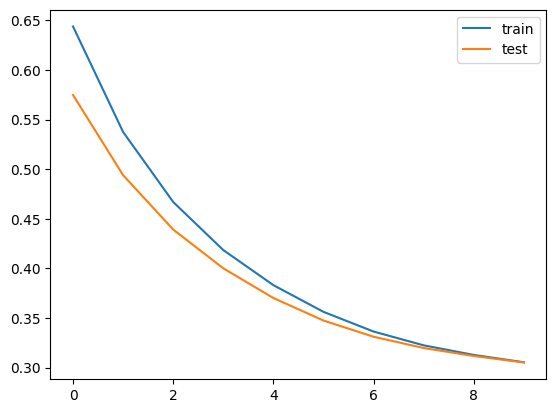

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

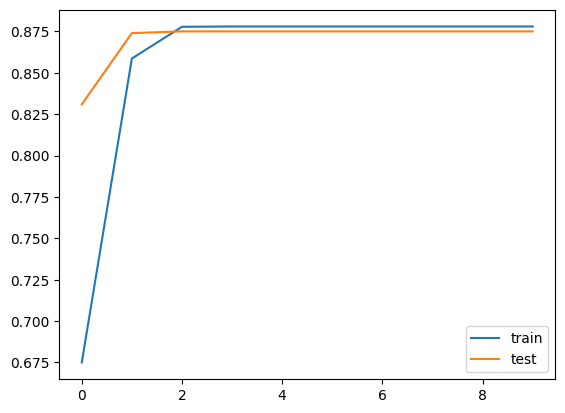

In [35]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [36]:
pred =  model.predict(X_test_scaled)

2382/2382 [==============================] - 3s 1ms/step


In [37]:
pred = np.where(pred<0.5,0,1)

In [38]:
np.unique(pred)

array([0])

In [39]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66699
           1       0.00      0.00      0.00      9523

    accuracy                           0.88     76222
   macro avg       0.44      0.50      0.47     76222
weighted avg       0.77      0.88      0.82     76222



#### Observation
  - Due to imbalance data we are getting worst prediction where precision and recall are both `0` 
  -  We can consulde that Majority class i.e `0` means customer who took life insurance but didn't show interest in vehicle insurance are more 
  - We can use undersampling where we drop majority class rows unless and untill its as same as minority class
  

In [40]:
df['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

#### Base Model with under sampling 

In [41]:
rus = RandomUnderSampler(
    sampling_strategy='auto',  # samples only the majority class
    random_state=0,  # for reproducibility
    replacement=False # if it should resample with replacement
)  

X_resampled, y_resampled = rus.fit_resample(df.drop('Response',axis=1), df['Response'])

In [42]:
X_resampled.shape, y_resampled.shape

((93420, 10), (93420,))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((74736, 10), (18684, 10), (74736,), (18684,))

In [45]:
pipe = Pipeline([
    ('OneHotEncoder', OneHotEncoder(variables=categorical_features,drop_last=True)),
    ('EqualFrequencyDiscretiser',EqualFrequencyDiscretiser(variables=['Annual_Premium'],q=10)),
    ('StandardScaler',StandardScaler())
])

In [46]:
pipe = pipe.fit(X_train,y_train)

In [47]:
X_train_scaled = pipe.transform(X_train)
X_test_scaled = pipe.transform(X_test)

In [48]:
model = Sequential()
model.add(Dense(32,input_dim=X_train_scaled.shape[1],activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [49]:
model.compile(optimizer='Adam',loss='BinaryCrossentropy',metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                384       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(X_train_scaled,y_train,batch_size=X_train_scaled.shape[0]//10,epochs=10,validation_data=(X_test_scaled,y_test))

Epoch 1/10
11/11 [==============================] - 1s 22ms/step - loss: 0.6792 - accuracy: 0.6020 - val_loss: 0.6436 - val_accuracy: 0.7076
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.6198 - accuracy: 0.7398 - val_loss: 0.5950 - val_accuracy: 0.7599
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.5760 - accuracy: 0.7698 - val_loss: 0.5596 - val_accuracy: 0.7690
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.5439 - accuracy: 0.7741 - val_loss: 0.5332 - val_accuracy: 0.7732
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.5197 - accuracy: 0.7769 - val_loss: 0.5132 - val_accuracy: 0.7750
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.5008 - accuracy: 0.7796 - val_loss: 0.4972 - val_accuracy: 0.7778
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.4869 - accuracy: 0.7828 - val_loss: 0.4863 - val_accuracy: 0.7801
Epoch 8/10
11/11 

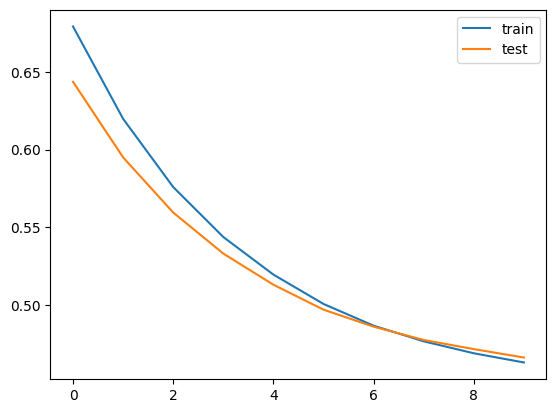

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

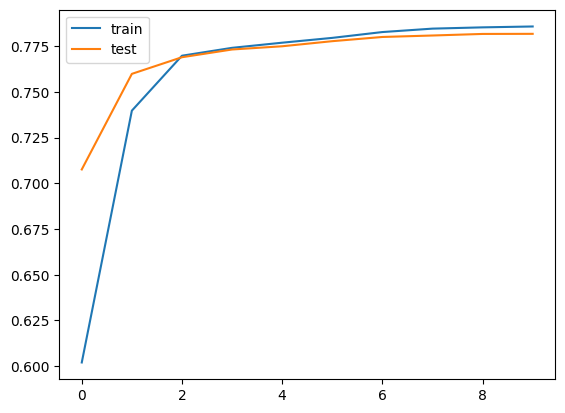

In [53]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [54]:
pred =  model.predict(X_test_scaled)

584/584 [==============================] - 1s 1ms/step


In [55]:
pred = np.where(pred<0.5,0,1)

In [56]:
np.unique(pred)

array([0, 1])

In [57]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.92      0.61      0.74      9346
           1       0.71      0.95      0.81      9338

    accuracy                           0.78     18684
   macro avg       0.82      0.78      0.78     18684
weighted avg       0.82      0.78      0.78     18684



#### Observation 
  - We used `Random Under Sampling` where we took the `Majority` class in our case it was `0` 
  - Drawback is we loss data of majority class.
  - But in our case we just want to look after customers who are interested in vehicle insurance i.e `1`.
  -  In our case we have to focus on `False Positive rate` i.e precision which had improved as compaird to last base mode that was `0` at that time but significantly improved when we use `RUS`.

#### What we can do to improve our model
  - use other imbalance technique.
  - use weight initialisation techniques in neural network.
  - weight normalisation in layers.
  - Hyper parameter tuning for layers and Neurons

#### Base model with Random Under Sampling and batch normalisation

In [58]:
model = Sequential()
model.add(Dense(32,input_dim=X_train_scaled.shape[1],activation='relu'))
BatchNormalization()
model.add(Dense(16,activation='relu'))
BatchNormalization()
model.add(Dense(1,activation='sigmoid'))

In [59]:
model.compile(optimizer='Adam',loss='BinaryCrossentropy',metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                384       
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(X_train_scaled,y_train,batch_size=X_train_scaled.shape[0]//10,epochs=10,validation_data=(X_test_scaled,y_test))

Epoch 1/10
11/11 [==============================] - 1s 23ms/step - loss: 0.7430 - accuracy: 0.4899 - val_loss: 0.7015 - val_accuracy: 0.5004
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.6799 - accuracy: 0.5158 - val_loss: 0.6524 - val_accuracy: 0.5411
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.6343 - accuracy: 0.5642 - val_loss: 0.6137 - val_accuracy: 0.5944
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.5982 - accuracy: 0.6193 - val_loss: 0.5821 - val_accuracy: 0.6462
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.5675 - accuracy: 0.6699 - val_loss: 0.5545 - val_accuracy: 0.6904
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.5411 - accuracy: 0.7111 - val_loss: 0.5312 - val_accuracy: 0.7271
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.5192 - accuracy: 0.7401 - val_loss: 0.5122 - val_accuracy: 0.7469
Epoch 8/10
11/11 

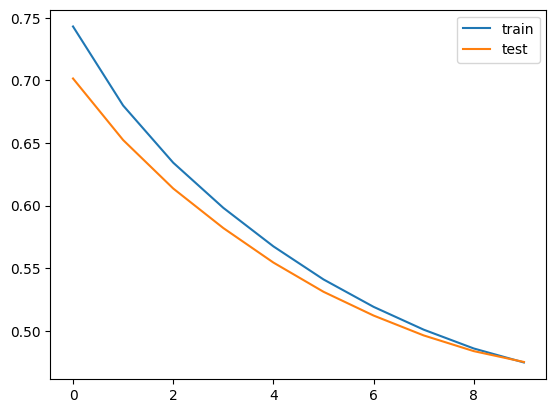

In [62]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

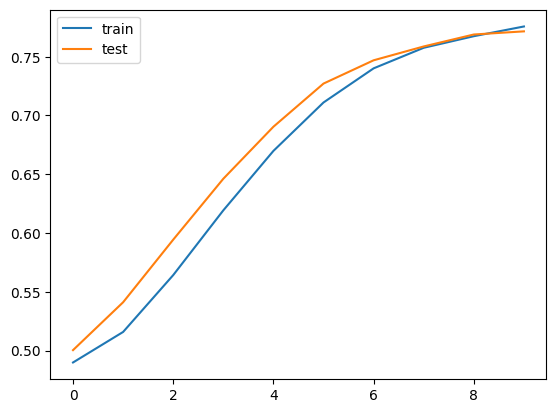

In [63]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [64]:
pred =  model.predict(X_test_scaled)

584/584 [==============================] - 1s 1ms/step


In [65]:
pred = np.where(pred<0.5,0,1)

In [66]:
np.unique(pred)

array([0, 1])

In [67]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.88      0.63      0.73      9346
           1       0.71      0.92      0.80      9338

    accuracy                           0.77     18684
   macro avg       0.80      0.77      0.77     18684
weighted avg       0.80      0.77      0.77     18684



#### Observation 
  - We had improvement in recall as well as precision when we added normalisation layers.

#### Hyper Parameter Tuning using keras tuner

In [74]:
def build_model(hp):
  model = Sequential()
  activitions = hp.Choice('activition',values = ['relu','sigmoid','tanh','softmax','softsign'])
  model.add(Dense(hp.Int('Nurons',8,64,8),activation=activitions,input_dim=X_train_scaled.shape[1]))
  BatchNormalization()
  for i in range(hp.Int('Layers',1,5,1)):
    model.add(Dense(hp.Int('Nurons',8,64,8),activation=hp.Choice(f'activition {i}',values = ['relu','sigmoid','tanh','softmax','softsign']),input_dim=X_train_scaled.shape[1]))
    BatchNormalization()
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer=hp.Choice(f'optimizer',values=['rmsprop','adagrad','adam','sgd']),loss='BinaryCrossentropy',metrics=['Accuracy'])
  return model

In [75]:
tuner = kt.RandomSearch(build_model,objective='val_Accuracy',max_trials=10)

In [76]:
tuner.search(X_train_scaled,y_train,batch_size=X_train_scaled.shape[0]//10,epochs=10,validation_data=(X_test_scaled,y_test))

Trial 10 Complete [00h 00m 02s]
val_Accuracy: 0.5251016616821289

Best val_Accuracy So Far: 0.771194577217102
Total elapsed time: 00h 00m 27s


In [77]:
tuner.get_best_hyperparameters()[0].values

{'Nurons': 16,
 'Layers': 5,
 'activition': 'relu',
 'activition 0': 'relu',
 'activition 1': 'softmax',
 'activition 2': 'softsign',
 'optimizer': 'rmsprop',
 'activition 3': 'tanh',
 'activition 4': 'tanh'}

In [80]:
model = tuner.get_best_models(num_models=1)[0]

In [87]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                192       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [82]:
history = model.fit(X_train_scaled,y_train,initial_epoch=11,batch_size=X_train_scaled.shape[0]//10,epochs=30,validation_data=(X_test_scaled,y_test))

Epoch 12/30
11/11 [==============================] - 0s 17ms/step - loss: 0.4420 - Accuracy: 0.7839 - val_loss: 0.4503 - val_Accuracy: 0.7786
Epoch 13/30
11/11 [==============================] - 0s 14ms/step - loss: 0.4412 - Accuracy: 0.7851 - val_loss: 0.4529 - val_Accuracy: 0.7776
Epoch 14/30
11/11 [==============================] - 0s 13ms/step - loss: 0.4409 - Accuracy: 0.7852 - val_loss: 0.4492 - val_Accuracy: 0.7782
Epoch 15/30
11/11 [==============================] - 0s 13ms/step - loss: 0.4398 - Accuracy: 0.7858 - val_loss: 0.4544 - val_Accuracy: 0.7767
Epoch 16/30
11/11 [==============================] - 0s 12ms/step - loss: 0.4403 - Accuracy: 0.7858 - val_loss: 0.4458 - val_Accuracy: 0.7806
Epoch 17/30
11/11 [==============================] - 0s 13ms/step - loss: 0.4383 - Accuracy: 0.7873 - val_loss: 0.4499 - val_Accuracy: 0.7790
Epoch 18/30
11/11 [==============================] - 0s 14ms/step - loss: 0.4383 - Accuracy: 0.7880 - val_loss: 0.4531 - val_Accuracy: 0.7749
Epoch 

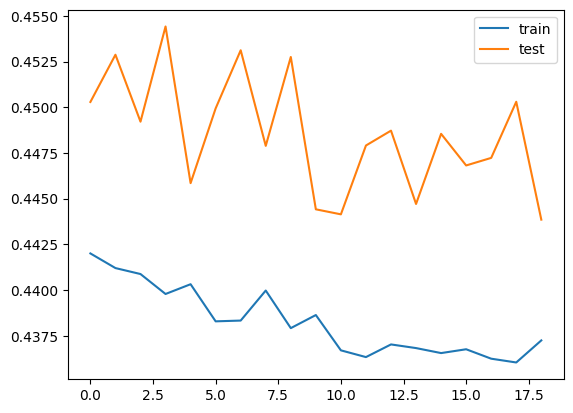

In [88]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

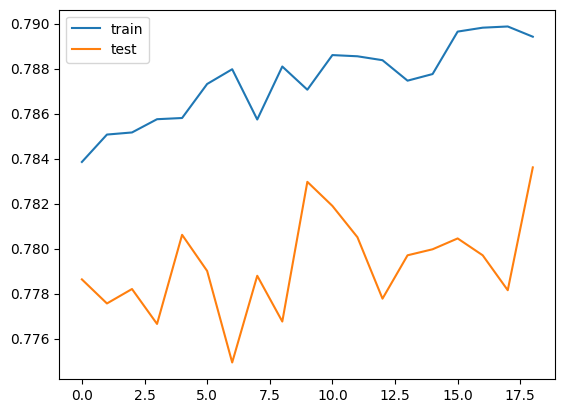

In [90]:
plt.plot(history.history['Accuracy'], label='train')
plt.plot(history.history['val_Accuracy'], label='test')
plt.legend()
plt.show()

In [83]:
pred =  model.predict(X_test_scaled)

584/584 [==============================] - 2s 2ms/step


In [84]:
pred = np.where(pred<0.5,0,1)

In [85]:
np.unique(pred)

array([0, 1])

In [86]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.91      0.63      0.74      9346
           1       0.72      0.94      0.81      9338

    accuracy                           0.78     18684
   macro avg       0.81      0.78      0.78     18684
weighted avg       0.81      0.78      0.78     18684

